In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import os
import shutil
import seaborn as sns
from scipy import stats
from ptm_dict import modres
from adjustText import adjust_text
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error as mae

In [2]:
# Block of seaborn style settings
plt.rc('font', size=23) #controls default text size
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=18) #fontsize of the x tick labels
plt.rc('ytick', labelsize=18) #fontsize of the y tick labels
sns.set(style='whitegrid', color_codes=True, font='serif', font_scale=2)

plt.rc('font', size=23) #controls default text size
plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
plt.rc('ytick', labelsize=25) #fontsize of the y tick labels

In [34]:
skempi2 = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi2_final.csv')
skempi2_raw = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi_v2.csv', sep=';')
skempi2_avg_nb = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempi2_nb.csv')

In [35]:
exp_cart_ddG_all = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/cart_ddG_IAM_full.csv')
#exp_cart_ddG_all = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/skempiMAX_cart_ddg_IA.csv')
exp_flex_ddG = pd.read_csv('flex_ddg_both_skempi2.csv')

In [36]:
# van_der_waals_volumes = {'A': 1.00, 'C': 2.43,
#                              'D': 2.78, 'E': 3.78,
#                              'F': 5.89, 'G': 0.00,
#                              'H': 4.66, 'I': 4.00,
#                              'K': 4.77, 'L': 4.00,
#                              'M': 4.43, 'N': 2.95,
#                              'P': 2.72, 'Q': 3.95,
#                              'R': 6.13, 'S': 1.60,
#                              'T': 2.60, 'V': 3.00,
#                              'W': 8.08, 'Y': 6.4}

In [37]:
def small_to_large(df):
    van_der_waals_volumes = {'G': 48,
 'A': 67,
 'S': 73,
 'C': 86,
 'T': 93,
 'P': 90,
 'D': 91,
 'N': 96,
 'V': 105,
 'E': 109,
 'Q': 114,
 'I': 124,
 'L': 124,
 'M': 124,
 'H': 118,
 'K': 135,
 'F': 135,
 'R': 148,
 'Y': 141,
 'W': 163}
    
    stl_list = list()
    for index, row in df.iterrows():
        muts = row['Mutation(s)_PDB'].split(',')
        stl = True
        for mut in muts:
            wt = mut[0]
            sub = mut[-1]
            if van_der_waals_volumes[sub]<=van_der_waals_volumes[wt]:
               stl = False
        stl_list.append(stl)
    df['small-to-large'] = stl_list

def interface_res(df):
    infc_res = ['W', 'F', 'Y', 'C', 'I', 'L', 'M', 'V', 'H', 'R']
    
    infc_tf = list()
    for index, row in df.iterrows():
        muts = row['Mutation(s)_PDB'].split(',')
        case_types = list()
        for mut in muts:
            wt = mut[0]
            sub = mut[-1]
            wt_infc = 'non-infc'
            sub_infc = 'non-infc'
            if wt in infc_res:
                wt_infc = 'infc'
            if sub in infc_res:
                sub_infc = 'infc'
                
            aa_infc = f'{wt_infc} to {sub_infc}'
    
            case_types.append(aa_infc)
            
        if len(set(case_types))>1 and len(muts)>1:
            aa_infc = 'mixed'
                
        infc_tf.append(aa_infc)
    df['type_of_change_infc'] = infc_tf

In [38]:
small_to_large(exp_cart_ddG_all)
interface_res(exp_cart_ddG_all)

In [39]:
S2536 = pd.read_csv('/groups/sbinlab/panf/SKEMPIv2_benchmark/S2536.csv', sep=';', na_values='XXX')

In [41]:
S2536_sub = pd.merge(S2536, exp_cart_ddG_all[['variant', 'mean_ddG', 'std_ddG',
                                              'mean_ddG_infc', 'std_ddG_infc',
                                              'PDB_ID', 'Mutation(s)_PDB',
                                              'Hold_out_type', 'small-to-large',
                                              'type_of_change_infc', 'iMutation_Location(s)',
                                              'N_mut']].drop_duplicates(),
                     left_on=['PDB', 'Mutation(s)_in_raw_pdb'], right_on=['PDB_ID', 'Mutation(s)_PDB'], how='left')

In [42]:
S2536_sub.loc[S2536_sub['mean_ddG'].isna()]

Entry   PDB Interacting Chains Mutation(s)  \
99           114,188  1BRS                A:D       DD39A   
262          439,451  2WPT                A:B       SB67A   
481         845,1262  1JTG                A:B       EA79K   
496         947,5776  1JTG                A:B       EA85A   
825        2080,3057  1DAN              HL:TU      VU113A   
1034       2434,3242  1CHO              EFG:I       TI14E   
2051       4728,4740  4I77               HL:Z      YH101A   
2058       4735,4747  4I77               HL:Z       YL32A   
2101  5327,5364,5441  3S9D                A:B       RA26A   
2356            6667  1C1Y                A:B       DA38A   
2357            6669  1LFD                A:B       YB32W   

     Mutation(s)_in_raw_pdb  Temperature  \
99                    DD39A       298.00   
262                   SB74A       298.00   
481                  EA104K       298.00   
496                  EA110A       297.00   
825                  VU207A       298.00   
1034                  TI17E       294.00   
2051                  YH98A       304.00   
2058                  YL28A       304.00   
2101                  RA33A       298.00   
2356                  DA38A       298.15   
2357                 YB232W       298.15   

                                              Reference   DDGb  DDGb_SK1  \
99    7739054,Water-mediated_interaction_at_a_protei...  6.790     6.790   
262                                            18471830 -0.134    -0.134   
481                                    9891008,21294157  3.239     4.233   
496                                   17070843,24947275  1.378     4.060   
825                                     7947809,7654692  0.690     0.690   
1034  11171964,Stephen_Ming-teh_Lu_PhD_Thesis_Purdue...  5.582     5.582   
2051                                           23357170  1.654       NaN   
2058                                           23357170  0.815       NaN   
2101                         10556041,10984492,21854986  5.123       NaN   
2356                                            8636102  2.620       NaN   
2357                                            8636102 -0.211       NaN   

        cRSA  ...  std_ddG  mean_ddG_infc  std_ddG_infc PDB_ID  \
99     0.968  ...      NaN            NaN           NaN   1BRS   
262    4.186  ...      NaN            NaN           NaN   2WPT   
481    6.048  ...      NaN            NaN           NaN   1JTG   
496    7.146  ...      NaN            NaN           NaN   1JTG   
825    2.422  ...      NaN            NaN           NaN   1DAN   
1034  16.190  ...      NaN            NaN           NaN   1CHO   
2051   8.374  ...      NaN            NaN           NaN   4I77   
2058  35.450  ...      NaN            NaN           NaN   4I77   
2101  10.682  ...      NaN            NaN           NaN   3S9D   
2356  11.212  ...      NaN            NaN           NaN   1C1Y   
2357  89.958  ...      NaN            NaN           NaN   1LFD   

     Mutation(s)_PDB Hold_out_type  small-to-large   type_of_change_infc  \
99             DD39A           NaN           False  non-infc to non-infc   
262            SB74A           NaN           False  non-infc to non-infc   
481           EA104K           NaN            True  non-infc to non-infc   
496           EA110A           NaN           False  non-infc to non-infc   
825           VU207A           NaN           False      infc to non-infc   
1034           TI17E         Pr/PI            True  non-infc to non-infc   
2051           YH98A         AB/AG           False      infc to non-infc   
2058           YL28A         AB/AG           False      infc to non-infc   
2101           RA33A           NaN           False      infc to non-infc   
2356           DA38A           NaN           False  non-infc to non-infc   
2357          YB232W           NaN            True          infc to infc   

      iMutation_Location(s)  N_mut  
99                      COR      1  
262                     COR      1  
481                    

In [43]:
S2536_sub_flex = pd.merge(S2536_sub, exp_flex_ddG[['PDB_ID', 'case_ID',
                                                   'Mutation(s)_PDB', 'flex_ddg',
                                                   'flex_ddg_gam']],
                     on =['PDB_ID','Mutation(s)_PDB'], how='left')

In [44]:
S2536_sub_flex.loc[S2536_sub_flex['flex_ddg'].isna()]

Entry   PDB Interacting Chains Mutation(s)  \
99           114,188  1BRS                A:D       DD39A   
262          439,451  2WPT                A:B       SB67A   
481         845,1262  1JTG                A:B       EA79K   
496         947,5776  1JTG                A:B       EA85A   
825        2080,3057  1DAN              HL:TU      VU113A   
1034       2434,3242  1CHO              EFG:I       TI14E   
2051       4728,4740  4I77               HL:Z      YH101A   
2058       4735,4747  4I77               HL:Z       YL32A   
2101  5327,5364,5441  3S9D                A:B       RA26A   

     Mutation(s)_in_raw_pdb  Temperature  \
99                    DD39A        298.0   
262                   SB74A        298.0   
481                  EA104K        298.0   
496                  EA110A        297.0   
825                  VU207A        298.0   
1034                  TI17E        294.0   
2051                  YH98A        304.0   
2058                  YL28A        304.0   
2101                  RA33A        298.0   

                                              Reference   DDGb  DDGb_SK1  \
99    7739054,Water-mediated_interaction_at_a_protei...  6.790     6.790   
262                                            18471830 -0.134    -0.134   
481                                    9891008,21294157  3.239     4.233   
496                                   17070843,24947275  1.378     4.060   
825                                     7947809,7654692  0.690     0.690   
1034  11171964,Stephen_Ming-teh_Lu_PhD_Thesis_Purdue...  5.582     5.582   
2051                                           23357170  1.654       NaN   
2058                                           23357170  0.815       NaN   
2101                         10556041,10984492,21854986  5.123       NaN   

        cRSA  ...  PDB_ID  Mutation(s)_PDB  Hold_out_type small-to-large  \
99     0.968  ...    1BRS            DD39A            NaN          False   
262    4.186  ...    2WPT            SB74A            NaN          False   
481    6.048  ...    1JTG           EA104K            NaN           True   
496    7.146  ...    1JTG           EA110A            NaN          False   
825    2.422  ...    1DAN           VU207A            NaN          False   
1034  16.190  ...    1CHO            TI17E          Pr/PI           True   
2051   8.374  ...    4I77            YH98A          AB/AG          False   
2058  35.450  ...    4I77            YL28A          AB/AG          False   
2101  10.682  ...    3S9D            RA33A            NaN          False   

       type_of_change_infc iMutation_Location(s)  N_mut  case_ID  flex_ddg  \
99    non-infc to non-infc                   COR      1      NaN       NaN   
262   non-infc to non-infc                   COR      1      NaN       NaN   
481   non-infc to non-infc                   COR      1      NaN       NaN   
496   non-infc to non-infc                   COR      1      NaN       NaN   
825       infc to non-infc                   COR      1      NaN       NaN   
1034  non-infc to non-infc                   COR      1      NaN       NaN   
2051      infc to non-infc                   COR      1      NaN       NaN   
2058      infc to non-infc                   RIM      1      NaN       NaN   
2101      infc to non-infc                   COR      1      NaN       NaN   

      flex_ddg_gam  
99             NaN  
262            NaN  
481            NaN  
496            NaN  
825            NaN  
1034           NaN  
2051           NaN  
2058           NaN  
2101           NaN  

[9 rows x 52 columns]

In [13]:
method_list = ['mCSM-PPI2', 'MutaBind2','BeAtMuSiC','SSIPe','SAAMBE-3D', 'NetTree', 'FoldX', 'BindProfX', 'mean_ddG', 'mean_ddG_infc', 'flex_ddg', 'flex_ddg_gam']
for m in method_list:
    
    subset = S2536_sub_flex.dropna(subset=[m])
    # display(S2536_sub_flex.loc[S2536_sub_flex[m].isna()])

    print(m)
    
    rp, pp = stats.pearsonr(subset['DDGb'], subset[m])
    print("Pearson's r: ", rp)
    
    rs, ps = stats.spearmanr(subset['DDGb'], subset[m])
    print("Spearman's r: ", rs)
    
    rmse = sqrt(mean_squared_error(subset['DDGb'], subset[m]))
    print("RMSE: ", rmse)

mCSM-PPI2
Pearson's r:  0.9065291316908531
Spearman's r:  0.8987088594840065
RMSE:  0.9533366631864078
MutaBind2
Pearson's r:  0.897611907912632
Spearman's r:  0.8484903338709076
RMSE:  0.9165447728199622
BeAtMuSiC
Pearson's r:  0.34474757049385885
Spearman's r:  0.4009712903423466
RMSE:  1.8985955934647216
SSIPe
Pearson's r:  0.5276366219154145
Spearman's r:  0.45752112273334994
RMSE:  1.7577948574964626
SAAMBE-3D
Pearson's r:  0.8792757413485541
Spearman's r:  0.845705801352014
RMSE:  1.0182251798289395
NetTree
Pearson's r:  0.1590801144220329
Spearman's r:  0.26721090477824744
RMSE:  2.367724713274055
FoldX
Pearson's r:  0.44314818696707736
Spearman's r:  0.4760858332064578
RMSE:  1.9850425612337148
BindProfX
Pearson's r:  0.5620237044515973
Spearman's r:  0.49663699233879943
RMSE:  1.6549291535164028
mean_ddG
Pearson's r:  0.41913974004417964
Spearman's r:  0.43304865538532955
RMSE:  2.0005076323850495
mean_ddG_infc
Pearson's r:  0.4431414778728552
Spearman's r:  0.4309585462540274

In [50]:
print('INTERFACE')
for m in ['mean_ddG', 'mean_ddG_infc', 'flex_ddg', 'flex_ddg_gam']:
    subset = S2536_sub_flex.dropna(subset=[m]).copy()
    subset = subset.loc[subset['interface']]

    print(m)
    
    rp, pp = stats.pearsonr(subset['DDGb'], subset[m])
    print("Pearson's r: ", rp)
    
    rs, ps = stats.spearmanr(subset['DDGb'], subset[m])
    print("Spearman's r: ", rs)
    
    rmse = sqrt(mean_squared_error(subset['DDGb'], subset[m]))
    print("RMSE: ", rmse)

    nrmse = sqrt(mean_squared_error(subset['DDGb'], subset[m]))/subset[m].std()
    print("nRMSE: ", nrmse)

print('')
print('NOT INTERFACE')
for m in ['mean_ddG', 'mean_ddG_infc', 'flex_ddg', 'flex_ddg_gam']:
    subset = S2536_sub_flex.dropna(subset=[m]).copy()
    subset = subset.loc[~subset['interface']]

    print(m)
    
    rp, pp = stats.pearsonr(subset['DDGb'], subset[m])
    print("Pearson's r: ", rp)
    
    rs, ps = stats.spearmanr(subset['DDGb'], subset[m])
    print("Spearman's r: ", rs)
    
    rmse = sqrt(mean_squared_error(subset['DDGb'], subset[m]))
    print("RMSE: ", rmse)

    nrmse = sqrt(mean_squared_error(subset['DDGb'], subset[m]))/subset[m].std()
    print("nRMSE: ", nrmse)

INTERFACE
mean_ddG
Pearson's r:  0.4331510979262393
Spearman's r:  0.458823115295453
RMSE:  2.100265649734998
nRMSE:  1.201125699692306
mean_ddG_infc
Pearson's r:  0.43198679639888193
Spearman's r:  0.4423831818621115
RMSE:  2.074850055770255
nRMSE:  1.491268132963034
flex_ddg
Pearson's r:  0.4603304588520343
Spearman's r:  0.47698201765618603
RMSE:  2.033018850972483
nRMSE:  1.2567110768097043
flex_ddg_gam
Pearson's r:  0.45061618196794195
Spearman's r:  0.4369466904661992
RMSE:  2.0188846708048303
nRMSE:  1.402693457430938

NOT INTERFACE
mean_ddG
Pearson's r:  0.2940075696602228
Spearman's r:  0.2669152244484625
RMSE:  1.6051197723295898
nRMSE:  1.1664621084754523
mean_ddG_infc
Pearson's r:  0.12464575070621764
Spearman's r:  0.11785292987931516
RMSE:  1.092820630501842
nRMSE:  2.9464421137993755
flex_ddg
Pearson's r:  0.29616923270766793
Spearman's r:  0.19567339724693525
RMSE:  1.0411395400205243
nRMSE:  2.852755906053063
flex_ddg_gam
Pearson's r:  0.34614966790369756
Spearman's r:

In [53]:
S2536.loc[S2536['interface']]

Entry   PDB Interacting Chains Mutation(s)  \
0                  1  1CSE                E:I       LI38G   
1                  2  1CSE                E:I       LI38S   
2                  3  1CSE                E:I       LI38P   
3                  4  1CSE                E:I       LI38I   
4                  5  1CSE                E:I       LI38D   
...              ...   ...                ...         ...   
2525            6927  5TAR                A:B       WB88A   
2526            6928  5TAR                A:B      QB114A   
2531            6933  4L0P                A:B       EA27K   
2533            6935  4L0P                A:B       TA76Q   
2535  7044,7045,7046  1YQV               HL:Y       RY45K   

     Mutation(s)_in_raw_pdb  Temperature Reference   DDGb  DDGb_SK1    cRSA  \
0                     LI45G        294.0   9048543  2.249     2.249   8.359   
1                     LI45S        294.0   9048543  1.172     1.172   8.359   
2                     LI45P        294.0   9048543  6.672     6.672   8.359   
3                     LI45I        294.0   9048543  2.941     2.941   8.359   
4                     LI45D        294.0   9048543  4.351     4.351   8.359   
...                     ...          ...       ...    ...       ...     ...   
2525                  WB90A        298.0  27791178  0.384       NaN  12.351   
2526                 QB116A        298.0  27791178  0.157       NaN  48.861   
2531                  EA53K        298.0  22242939  2.665       NaN   8.045   
2533                 TA102Q        298.0  22242939  1.472       NaN   0.000   
2535                  RY45K        297.0   9252107  1.867       NaN   3.279   

      ...  SAAMBE-3D  SAAMBE-3D_rev   NetTree NetTree_rev   FoldX FoldX_rev  \
0     ...   2.812825       0.530206  1.676192    1.527064  3.0042    3.3443   
1     ...   1.543789       1.109185  2.706162    1.402388  3.2729   -2.5399   
2     ...   5.933657       0.615902  3.116857    0.448269  3.1117   -1.8050   
3     ...   2.560643       1.281160  1.463532    1.199537  2.5986   -0.9517   
4     ...   4.143629       1.001774  3.296694    1.180625  2.6593   -1.9353   
...   ...        ...            ...       ...         ...     ...       ...   
2525  ...   1.117271      -0.267702  3.943460    1.737200  1.6906   -0.6065   
2526  ...   0.964587      -0.290519  0.754421    0.980636  0.2319   -0.2605   
2531  ...   1.417446       1.253170  2.783903    4.947306  4.0381   -3.6124   
2533  ...   0.759861       0.816764  2.901882    1.486909  4.3408   -1.9547   
2535  ...   1.247154       1.001248  3.912203    1.456964  1.1376   -1.7402   

      BindProfX  BindProfX_rev  consensus  consensus_rev  
0        2.6480        -0.1430   2.751777       0.162946  
1        2.6710        -1.7170   2.494856      -0.688041  
2        2.6960        -1.4480   3.973277      -1.205229  
3        2.3510        -1.2850   2.098347      -0.502125  
4        2.5390        -1.5260   3.235453      -0.653613  
...         ...            ...        ...            ...  
2525     1.9860        -0.1520   2.102916      -0.319375  
2526     0.6420         0.7960   0.461488       0.129827  
2531     1.9970        -1.1220   2.121806      -0.102740  
2533     2.1520        -0.5730   2.038568      -0.541753  
2535     1.1376        -1.7402   1.751445      -0.304149  

[1972 rows x 37 columns]

In [22]:
for m in method_list:
    
    subset = S2536_sub_flex.dropna(subset=[m])
    
    #display(exp_cart_flex_C380.loc[exp_cart_flex_C380[m].isna()])

    print(m)
    
    rp, pp = stats.pearsonr(subset['DDGb'], subset[m])
    print("Pearson's r: ", rp)
    
    rs, ps = stats.spearmanr(subset['DDGb'], subset[m])
    print("Spearman's r: ", rs)
    
    rmse = sqrt(mean_squared_error(subset['DDGb'],  subset[m]))
    print("RMSE: ", rmse)

    print('min', subset[m].min(), 'max', subset[m].max())

    print('Small-to-large')
    
    subset_stl = subset.loc[subset['small-to-large']==True]

    rp, pp = stats.pearsonr(subset_stl['DDGb'], subset_stl[m])
    print("Pearson's r: ", rp)
    
    rs, ps = stats.spearmanr(subset_stl['DDGb'], subset_stl[m])
    print("Spearman's r: ", rs)
    
    rmse = sqrt(mean_squared_error(subset_stl['DDGb'],  subset_stl[m]))
    print("RMSE: ", rmse)

    print('Large-to-small')
    
    subset_stl = subset.loc[subset['small-to-large']==False]

    rp, pp = stats.pearsonr(subset_stl['DDGb'], subset_stl[m])
    print("Pearson's r: ", rp)
    
    rs, ps = stats.spearmanr(subset_stl['DDGb'], subset_stl[m])
    print("Spearman's r: ", rs)
    
    rmse = sqrt(mean_squared_error(subset_stl['DDGb'],  subset_stl[m]))
    print("RMSE: ", rmse)


mCSM-PPI2
Pearson's r:  0.9065291316908531
Spearman's r:  0.8987088594840065
RMSE:  0.9533366631864078
min -6.617 max 9.686
Small-to-large
Pearson's r:  0.9026377701308537
Spearman's r:  0.9091729913868598
RMSE:  1.1360221438688811
Large-to-small
Pearson's r:  0.9082589444357335
Spearman's r:  0.898203330893774
RMSE:  0.8715299792104939
MutaBind2
Pearson's r:  0.897611907912632
Spearman's r:  0.8484903338709076
RMSE:  0.9165447728199622
min -10.2 max 10.09
Small-to-large
Pearson's r:  0.893271929825548
Spearman's r:  0.8464644800326904
RMSE:  1.029272767138289
Large-to-small
Pearson's r:  0.8965976147522565
Spearman's r:  0.8485549898993738
RMSE:  0.8684839108159303
BeAtMuSiC
Pearson's r:  0.34474757049385885
Spearman's r:  0.4009712903423466
RMSE:  1.8985955934647216
min -1.89 max 5.61
Small-to-large
Pearson's r:  0.10748664034097574
Spearman's r:  0.17348992474756544
RMSE:  2.273573585157257
Large-to-small
Pearson's r:  0.4021986909761906
Spearman's r:  0.4660402886291202
RMSE:  1.72

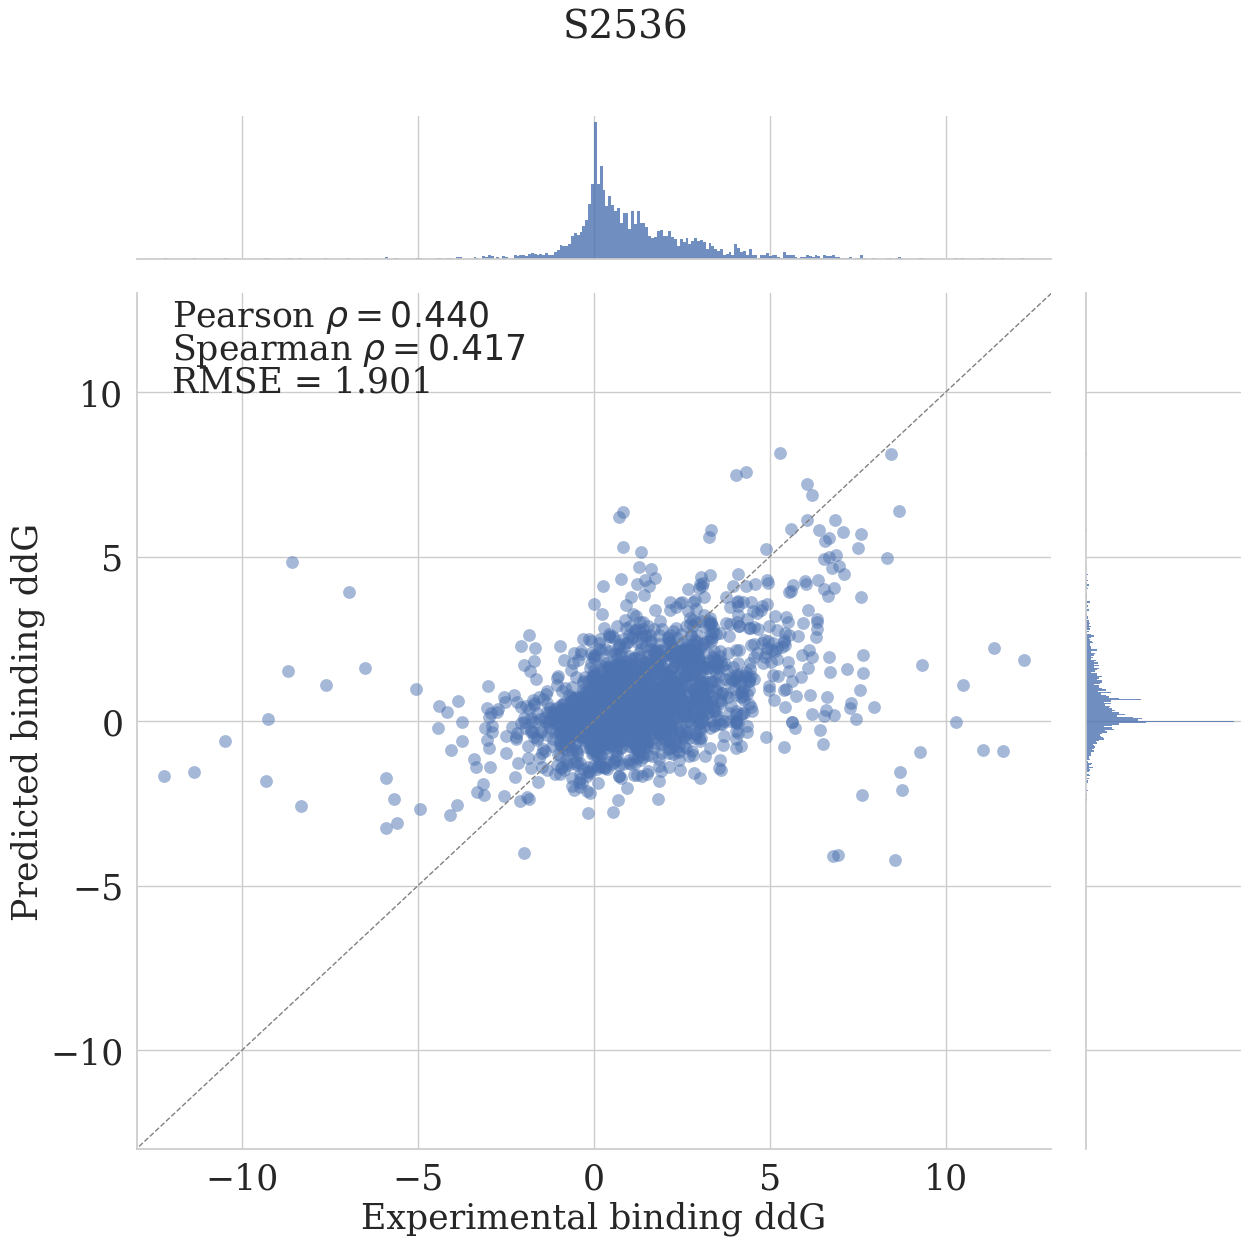

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

df = S2536_sub.dropna(subset=['mean_ddG_infc'])

# Set up the JointGrid
g = sns.JointGrid(data=df, x='DDGb', y='mean_ddG_infc',
                  height=13,  # Adjust overall figure size
                  xlim=(-13, 13), ylim=(-13, 13))

#g = g.plot(sns.scatterplot, sns.kdeplot, alpha=0.5, linewidth=0, size=65)
g.plot_joint(sns.scatterplot, alpha=0.5, linewidth=0, s=85)
# g.plot_marginals(sns.kdeplot, fill=True, alpha=0.6, linewidth=0)
g.plot_marginals(sns.histplot, fill=True, alpha=0.8, linewidth=0, bins=300)

# Add labels and title
g.set_axis_labels(xlabel='Experimental binding ddG', ylabel='Predicted binding ddG', fontsize=25)
g.fig.suptitle('S2536', fontsize=28, y=1) # Adjust suptitle position


# Add the diagonal line
min_val = -15 - 1.5
max_val = 15 + 1.5
g.ax_joint.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

# Calculate and annotate Pearson correlation coefficients
r_p, p_p = stats.pearsonr(df['DDGb'], df['mean_ddG_infc'])
g.ax_joint.annotate(f"Pearson $\\rho = {r_p:.3f}$", xy=(-12, 12), fontsize = 25)

r_s, p_s = stats.spearmanr(df['DDGb'], df['mean_ddG_infc'])
g.ax_joint.annotate(f'Spearman $\\rho = {r_s:.3f}$', xy=(-12, 11), fontsize = 25)

rmse = sqrt(mean_squared_error(df['DDGb'], df['mean_ddG_infc']))
g.ax_joint.annotate(f'RMSE = {rmse:.3f}', xy=(-12, 10), fontsize = 25)

# # Add a legend to distinguish hue subgroups
# g.ax_joint.legend(title='Number of Mutations', fontsize=15, title_fontsize=18)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 1]) # Adjust rect to prevent suptitle overlap
plt.savefig('Figures/S2536.pdf', format='pdf')

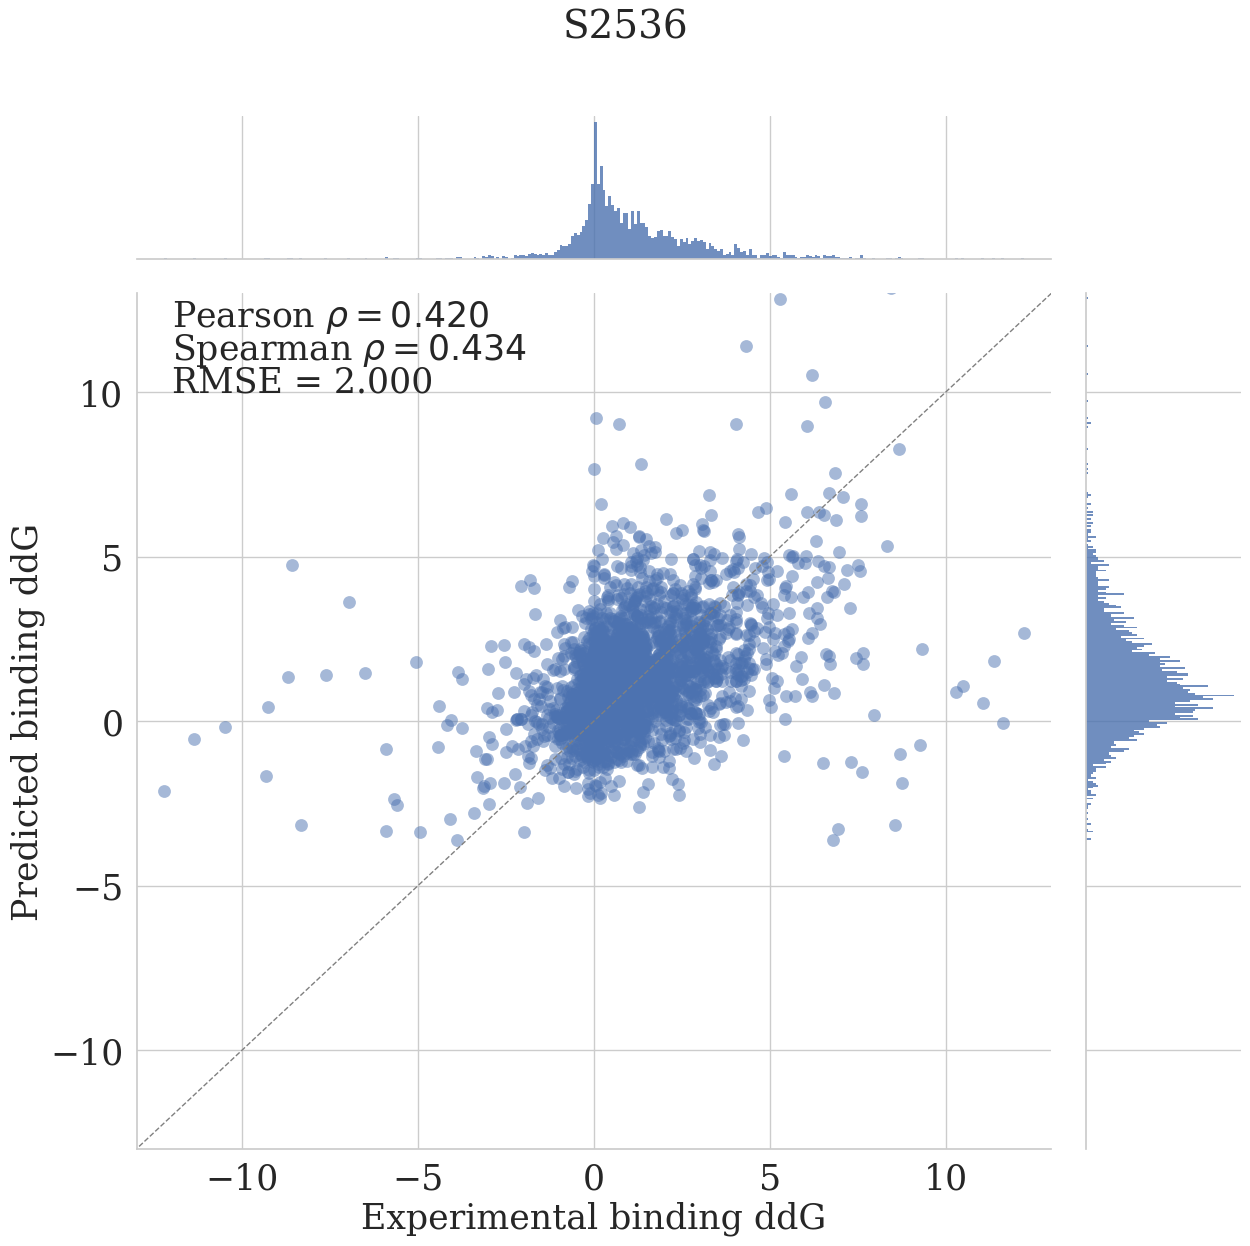

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

df = S2536_sub.dropna(subset=['mean_ddG'])

# Set up the JointGrid
g = sns.JointGrid(data=df, x='DDGb', y='mean_ddG',
                  height=13,  # Adjust overall figure size
                  xlim=(-13, 13), ylim=(-13, 13))

#g = g.plot(sns.scatterplot, sns.kdeplot, alpha=0.5, linewidth=0, size=65)
g.plot_joint(sns.scatterplot, alpha=0.5, linewidth=0, s=85)
# g.plot_marginals(sns.kdeplot, fill=True, alpha=0.6, linewidth=0)
g.plot_marginals(sns.histplot, fill=True, alpha=0.8, linewidth=0, bins=300)

# Add labels and title
g.set_axis_labels(xlabel='Experimental binding ddG', ylabel='Predicted binding ddG', fontsize=25)
g.fig.suptitle('S2536', fontsize=28, y=1) # Adjust suptitle position


# Add the diagonal line
min_val = -15 - 1.5
max_val = 15 + 1.5
g.ax_joint.plot([min_val, max_val], [min_val, max_val], color='gray', ls='--', lw=1)

# Calculate and annotate Pearson correlation coefficients
r_p, p_p = stats.pearsonr(df['DDGb'], df['mean_ddG'])
g.ax_joint.annotate(f"Pearson $\\rho = {r_p:.3f}$", xy=(-12, 12), fontsize = 25)

r_s, p_s = stats.spearmanr(df['DDGb'], df['mean_ddG'])
g.ax_joint.annotate(f'Spearman $\\rho = {r_s:.3f}$', xy=(-12, 11), fontsize = 25)

rmse = sqrt(mean_squared_error(df['DDGb'], df['mean_ddG']))
g.ax_joint.annotate(f'RMSE = {rmse:.3f}', xy=(-12, 10), fontsize = 25)

# # Add a legend to distinguish hue subgroups
# g.ax_joint.legend(title='Number of Mutations', fontsize=15, title_fontsize=18)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 1]) # Adjust rect to prevent suptitle overlap
#plt.savefig('Figures/S2536.pdf', format='pdf')

In [14]:
for msp in ['mean_ddG', 'mean_ddG_infc', 'flex_ddg', 'flex_ddg_gam', 'DDGb']:
    print(msp, ' max', np.nanmax(S2536_sub_flex[msp]))
    print(msp, ' min', np.nanmin(S2536_sub_flex[msp]))

mean_ddG  max 13.157816091953968
mean_ddG  min -3.609655172413897
mean_ddG_infc  max 8.139597097422604
mean_ddG_infc  min -4.233776173432385
flex_ddg  max 12.73611
flex_ddg  min -4.65945
flex_ddg_gam  max 11.072494910792344
flex_ddg_gam  min -3.934067143513864
DDGb  max 12.222
DDGb  min -12.222


In [15]:
for sf in sep_feature.keys():
    print(df[sf].unique())

NameError: name 'sep_feature' is not defined

In [ ]:
S2536_sub_flex

In [91]:
#S2536_sub_flex['Hold_out_type'] = S2536_sub_flex['Hold_out_type'].fillna('None')

In [119]:
df['Hold_out_type'].dropna().unique()

array(['Pr/PI', 'AB/AG', 'AB/AG,Pr/PI', 'TCR/pMHC'], dtype=object)

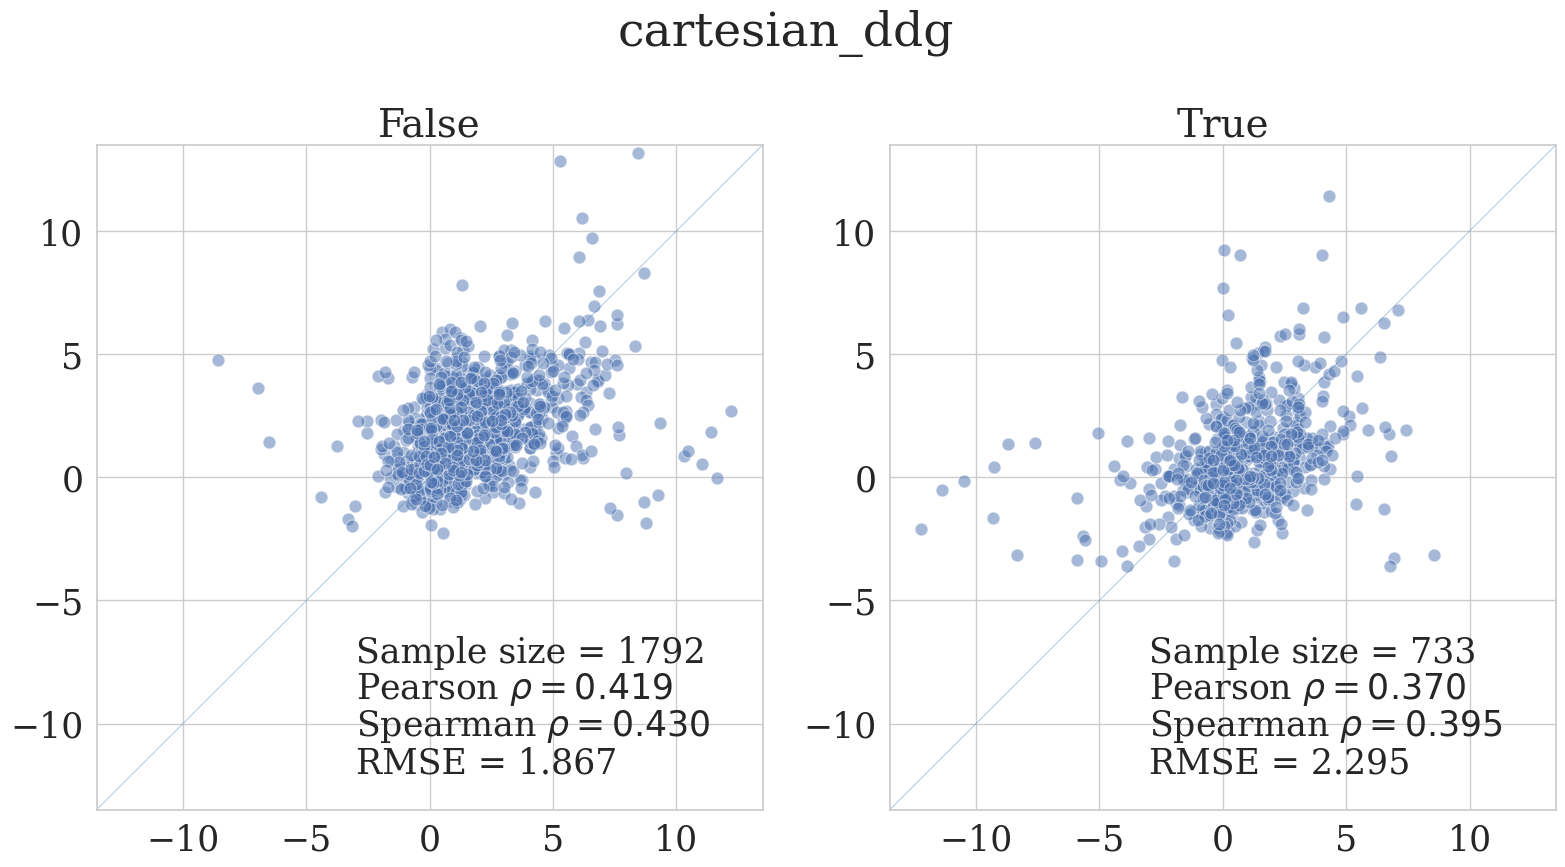

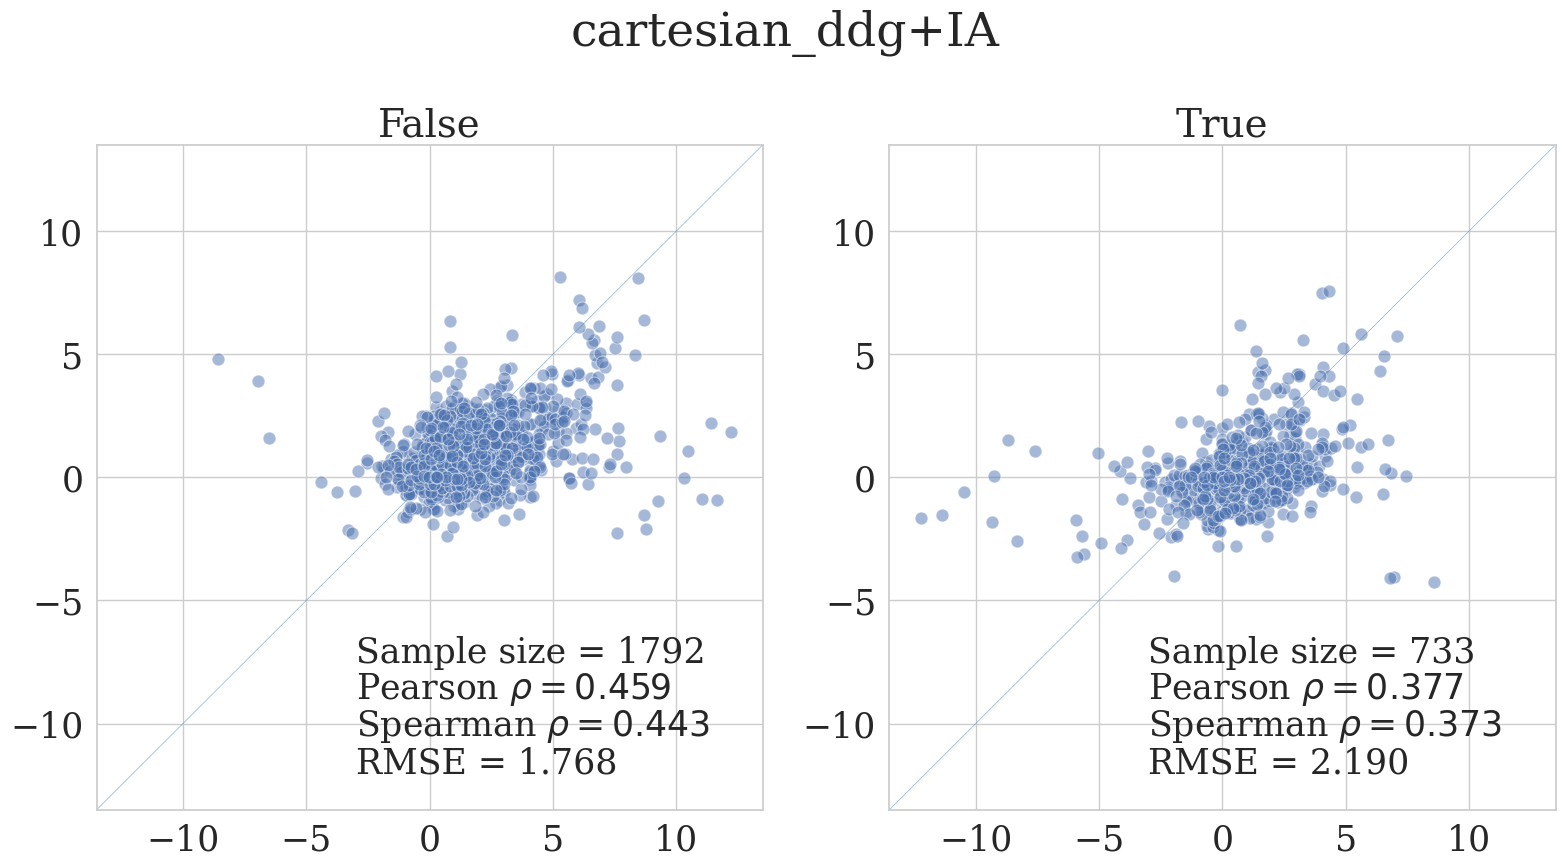

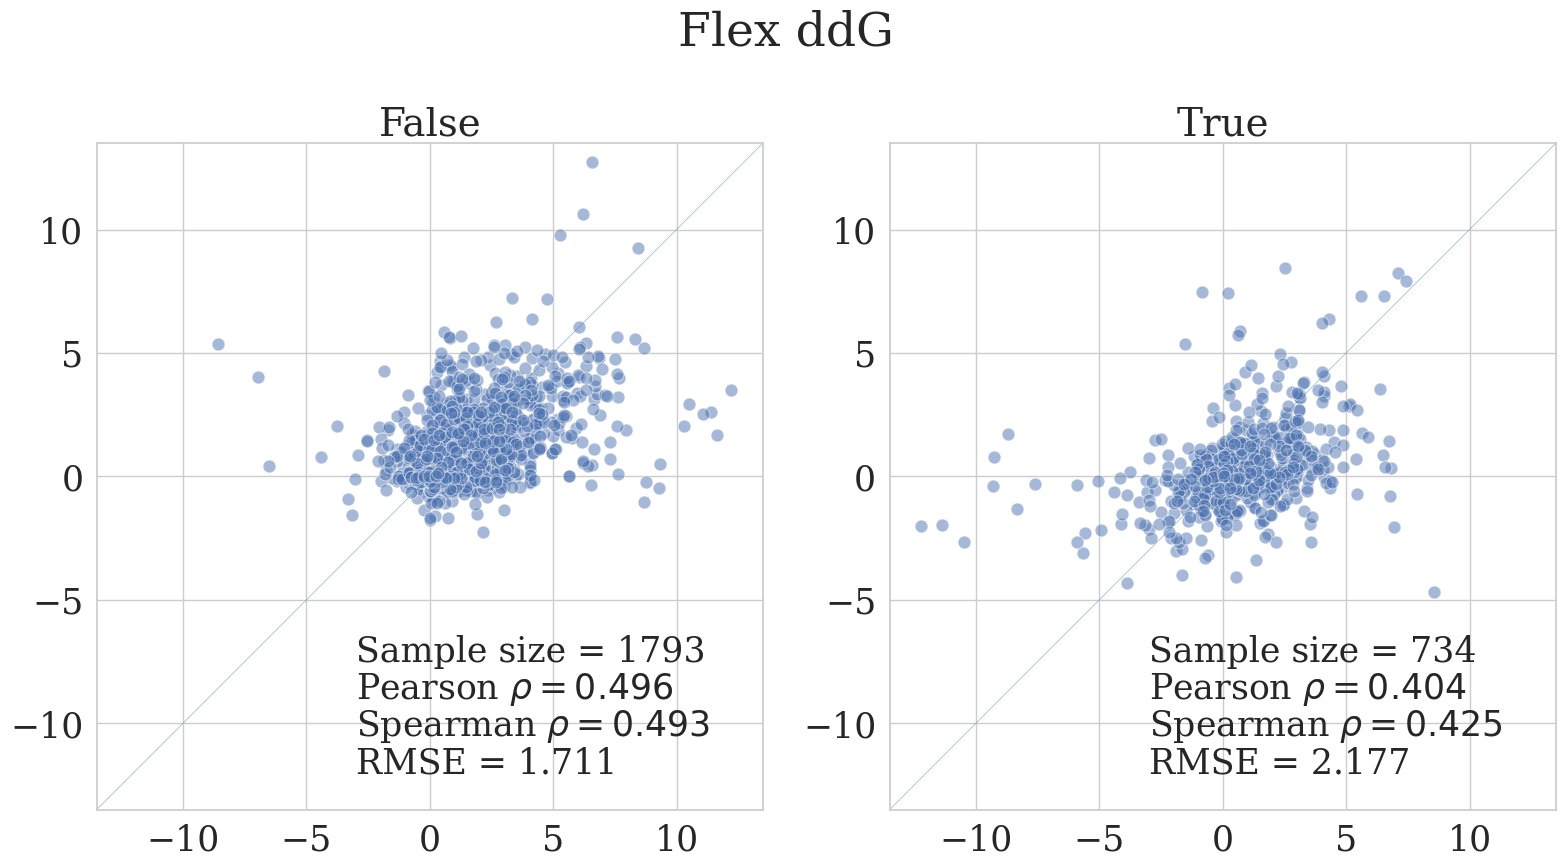

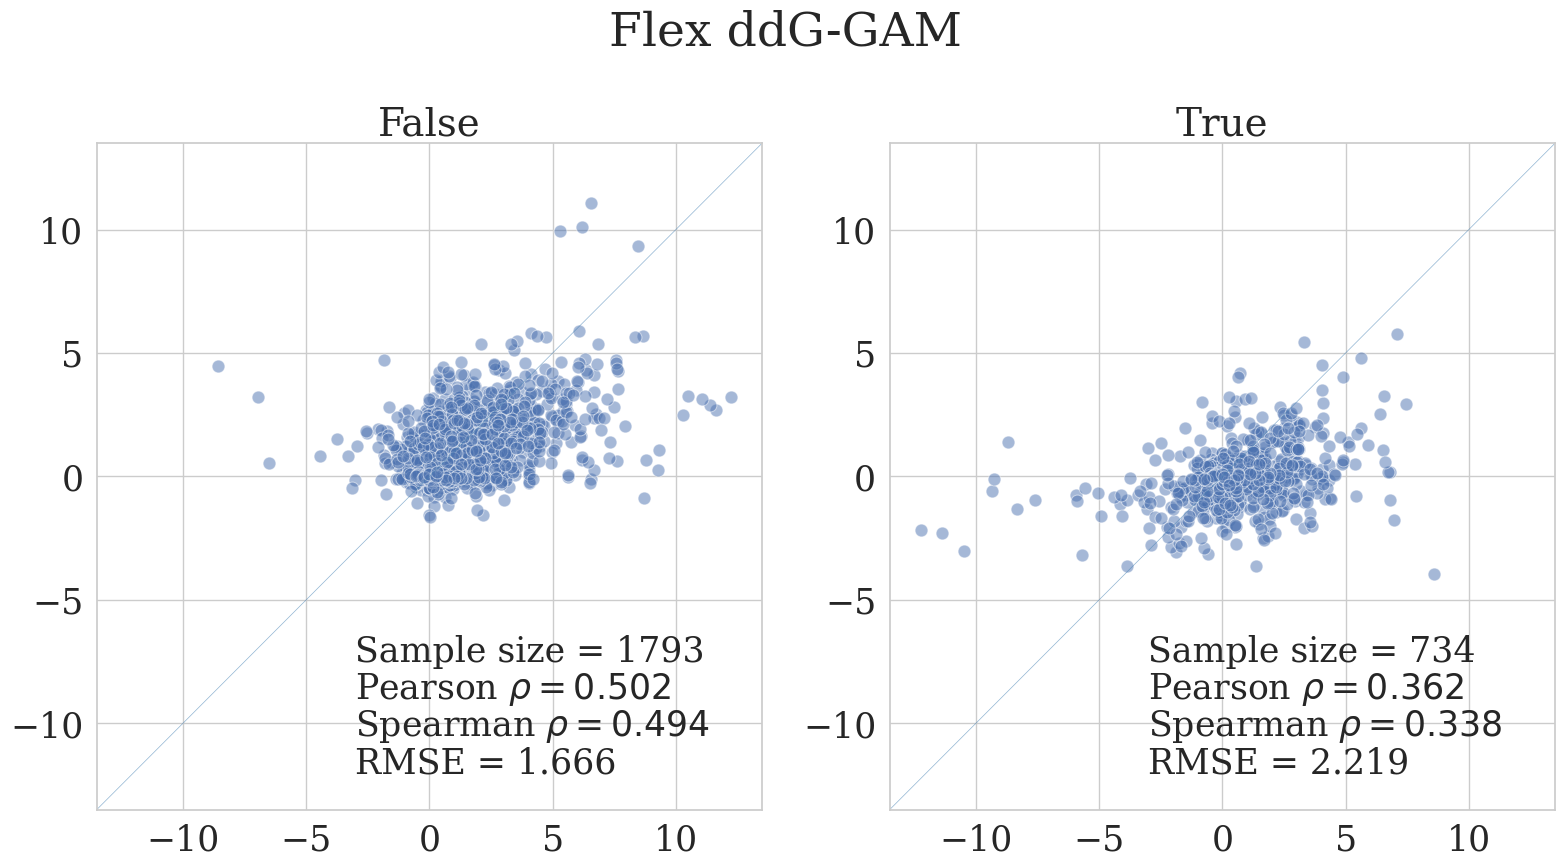

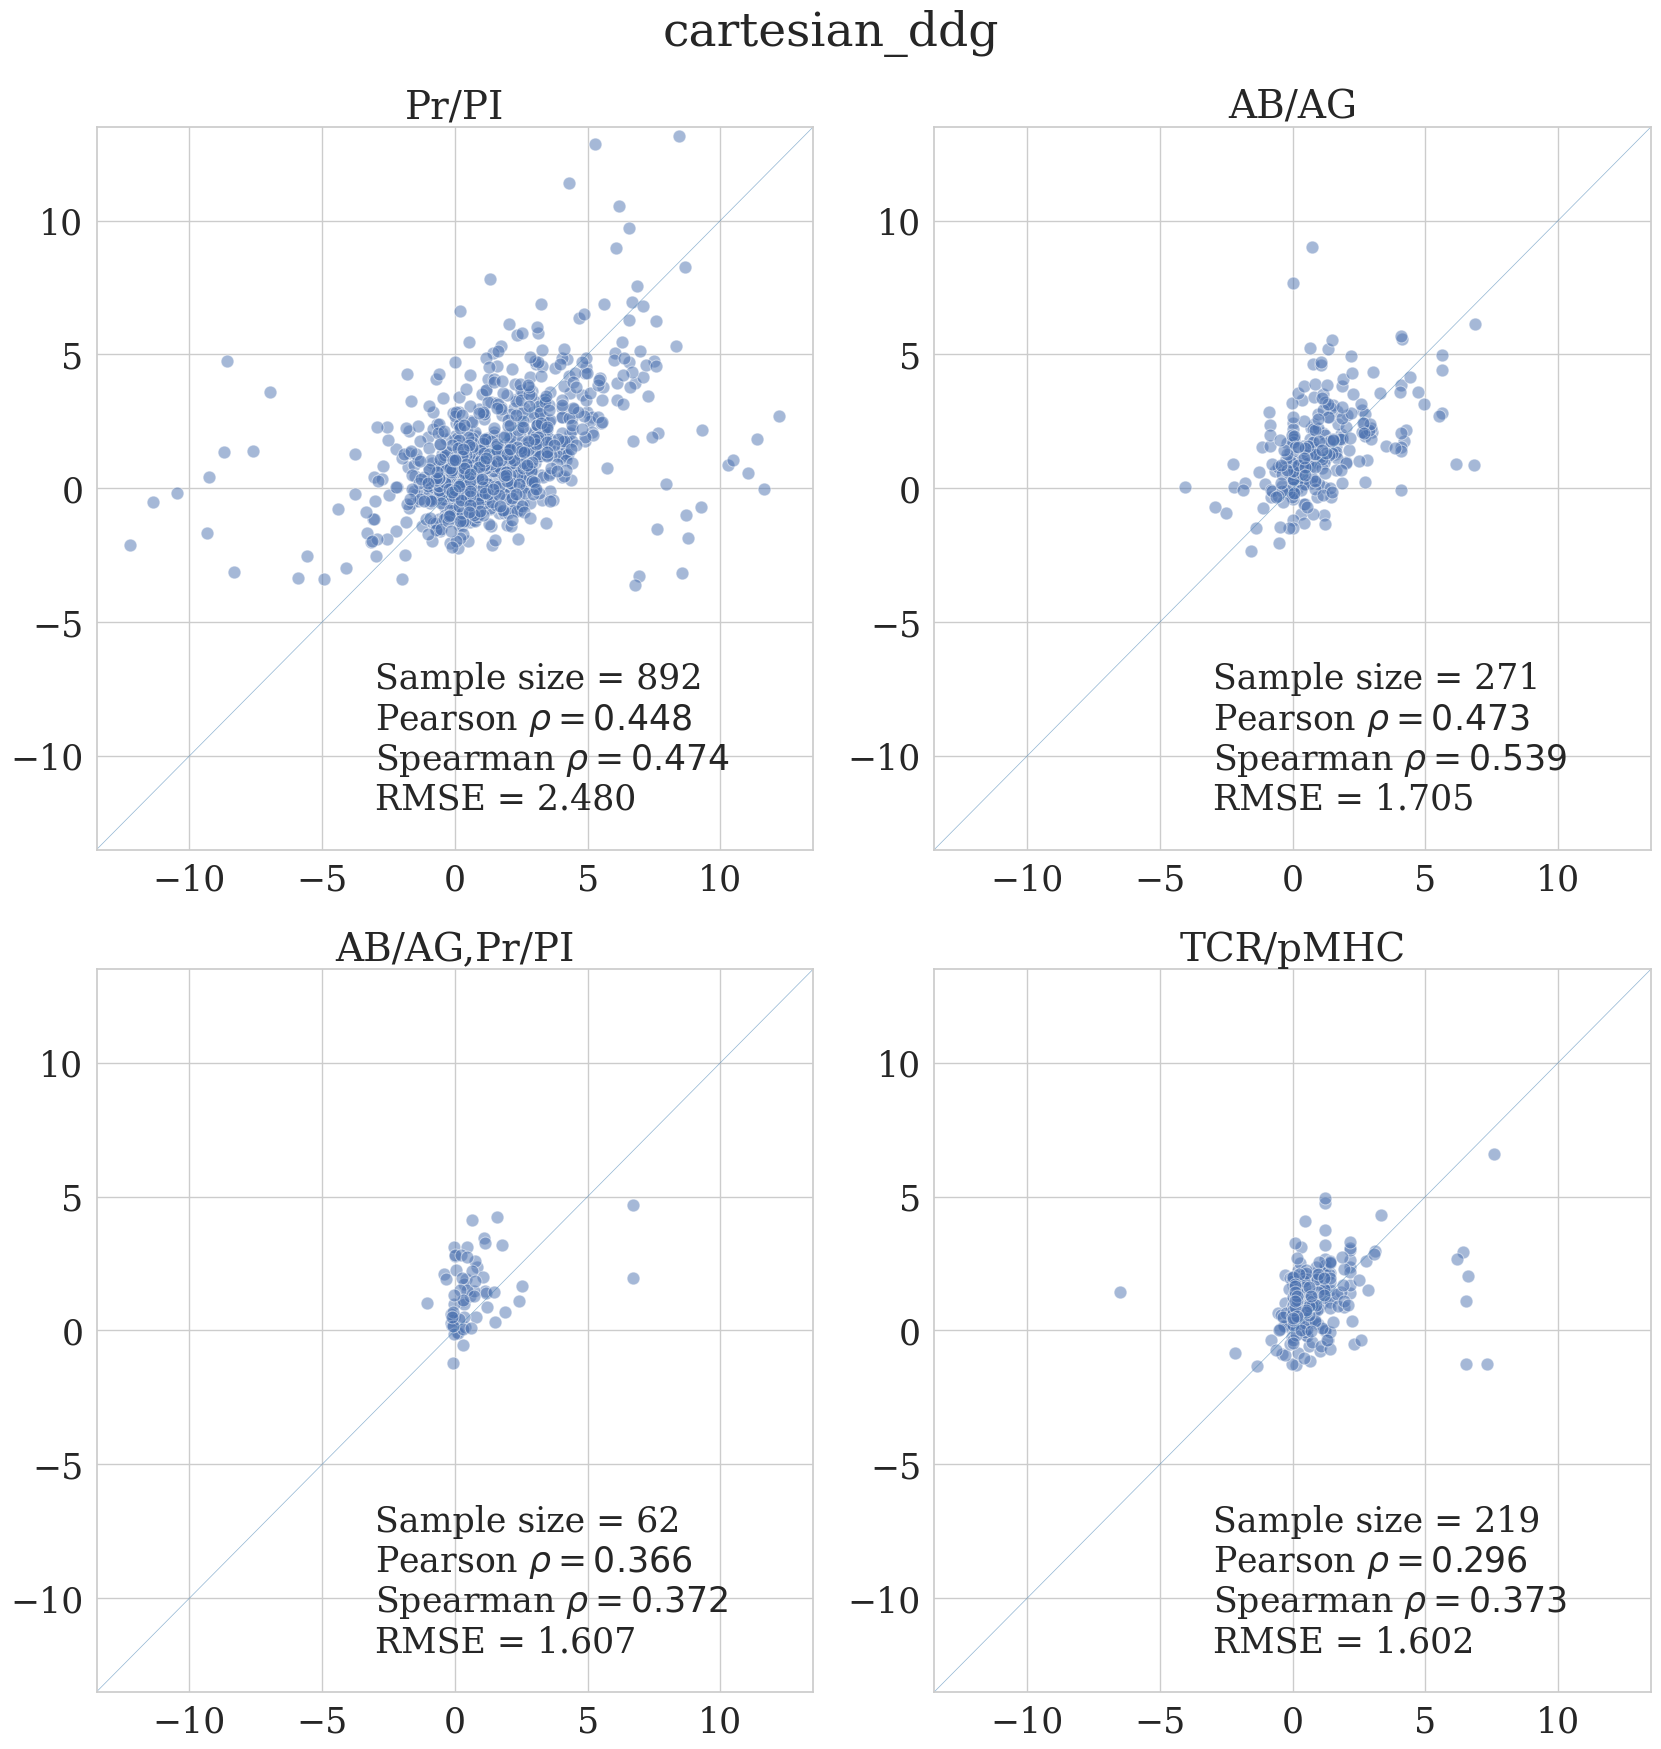

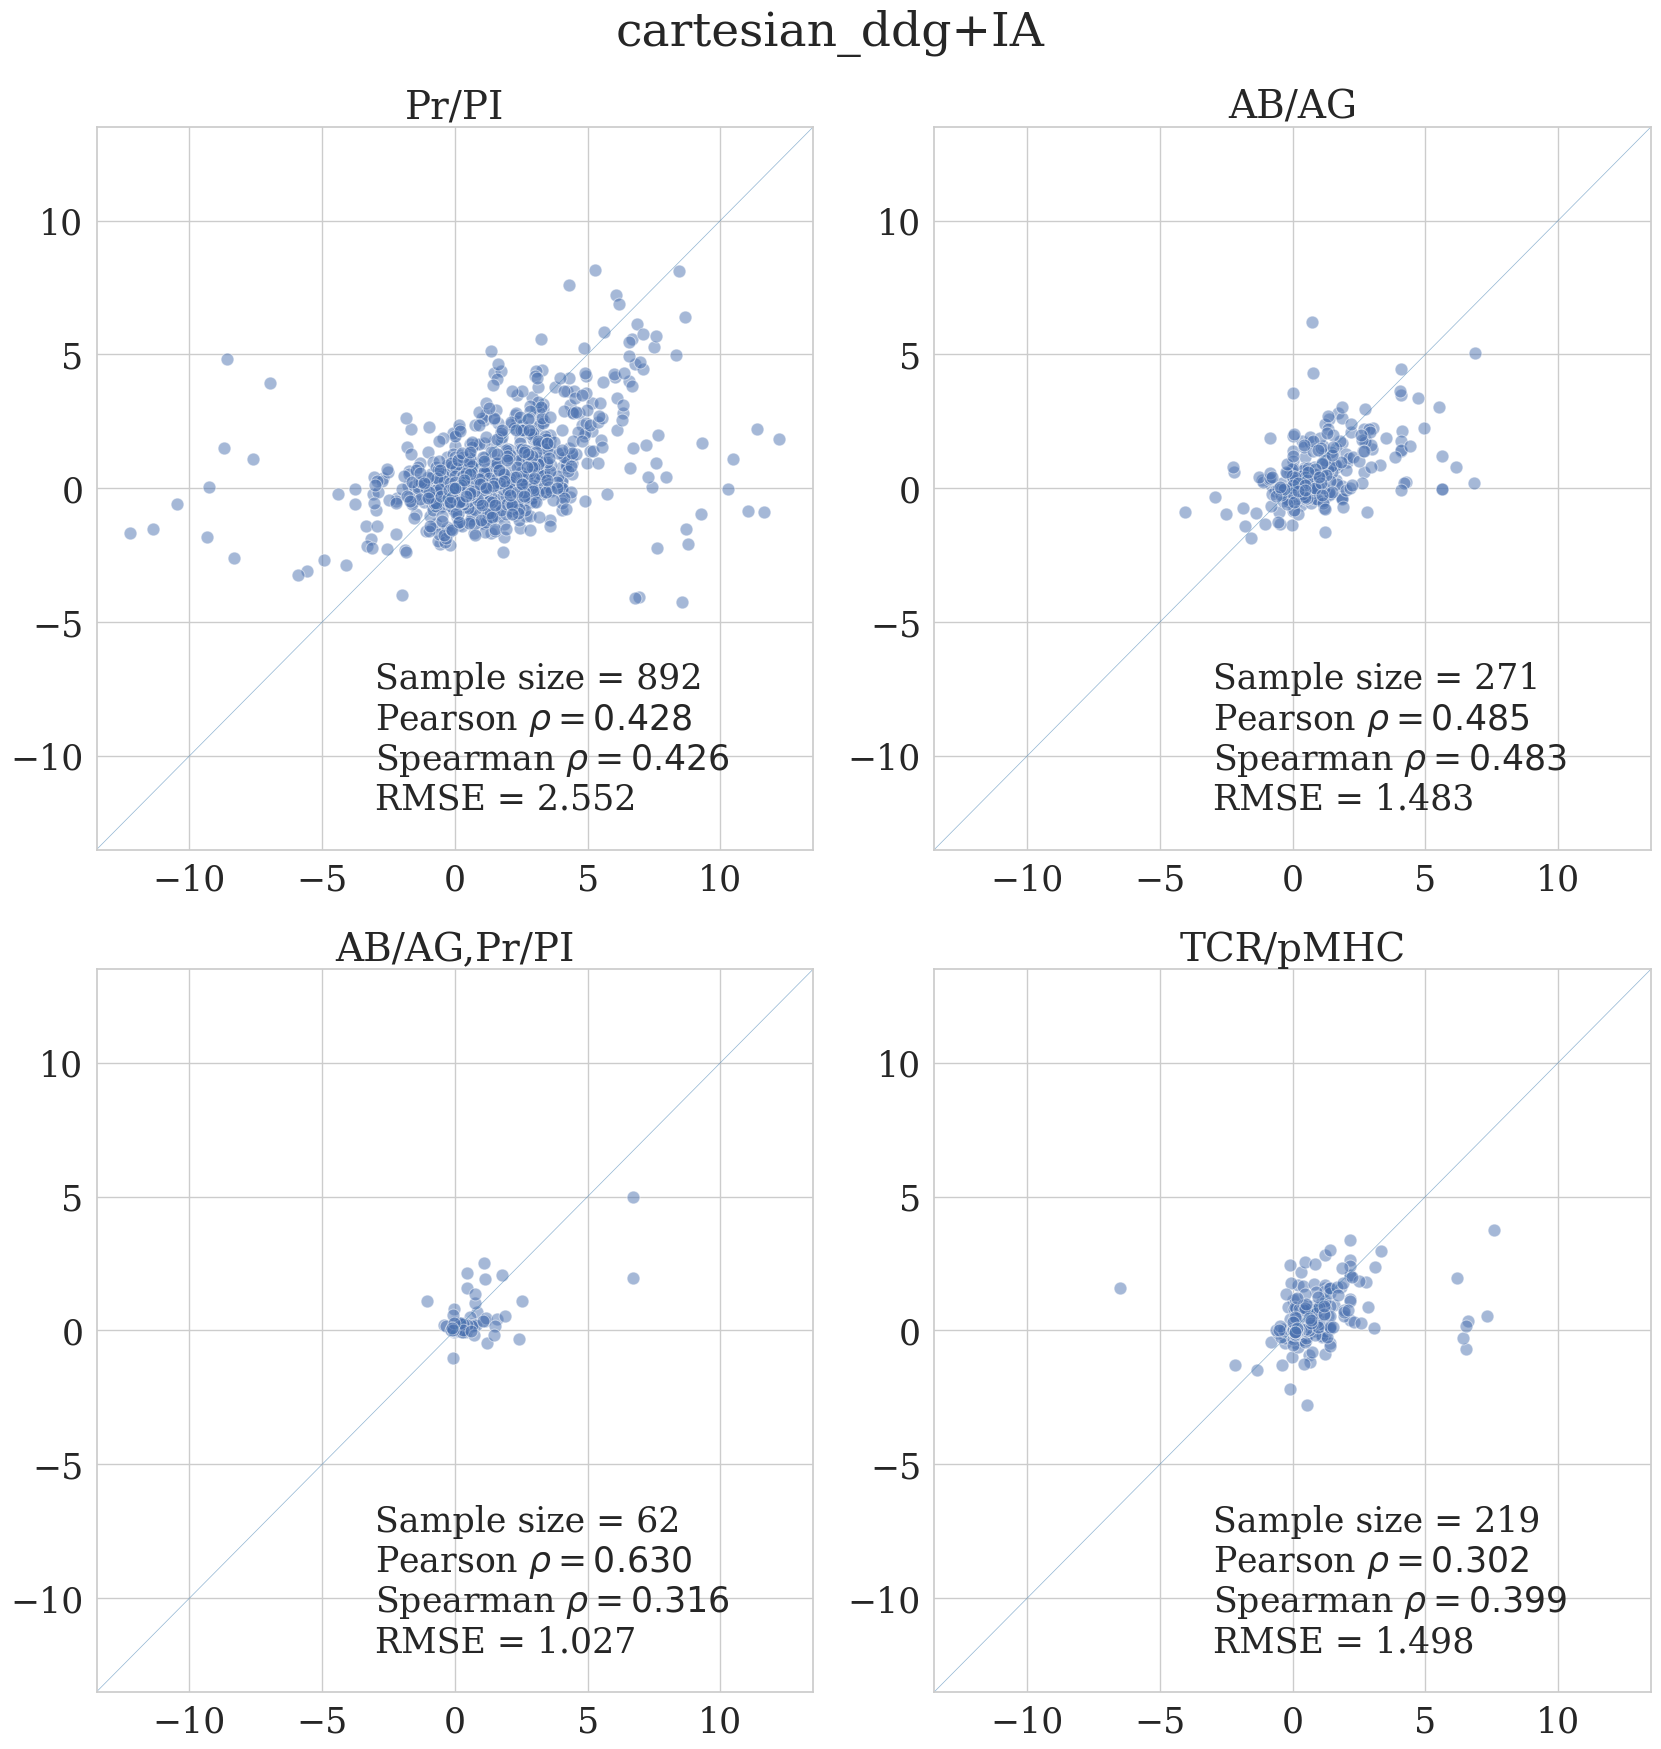

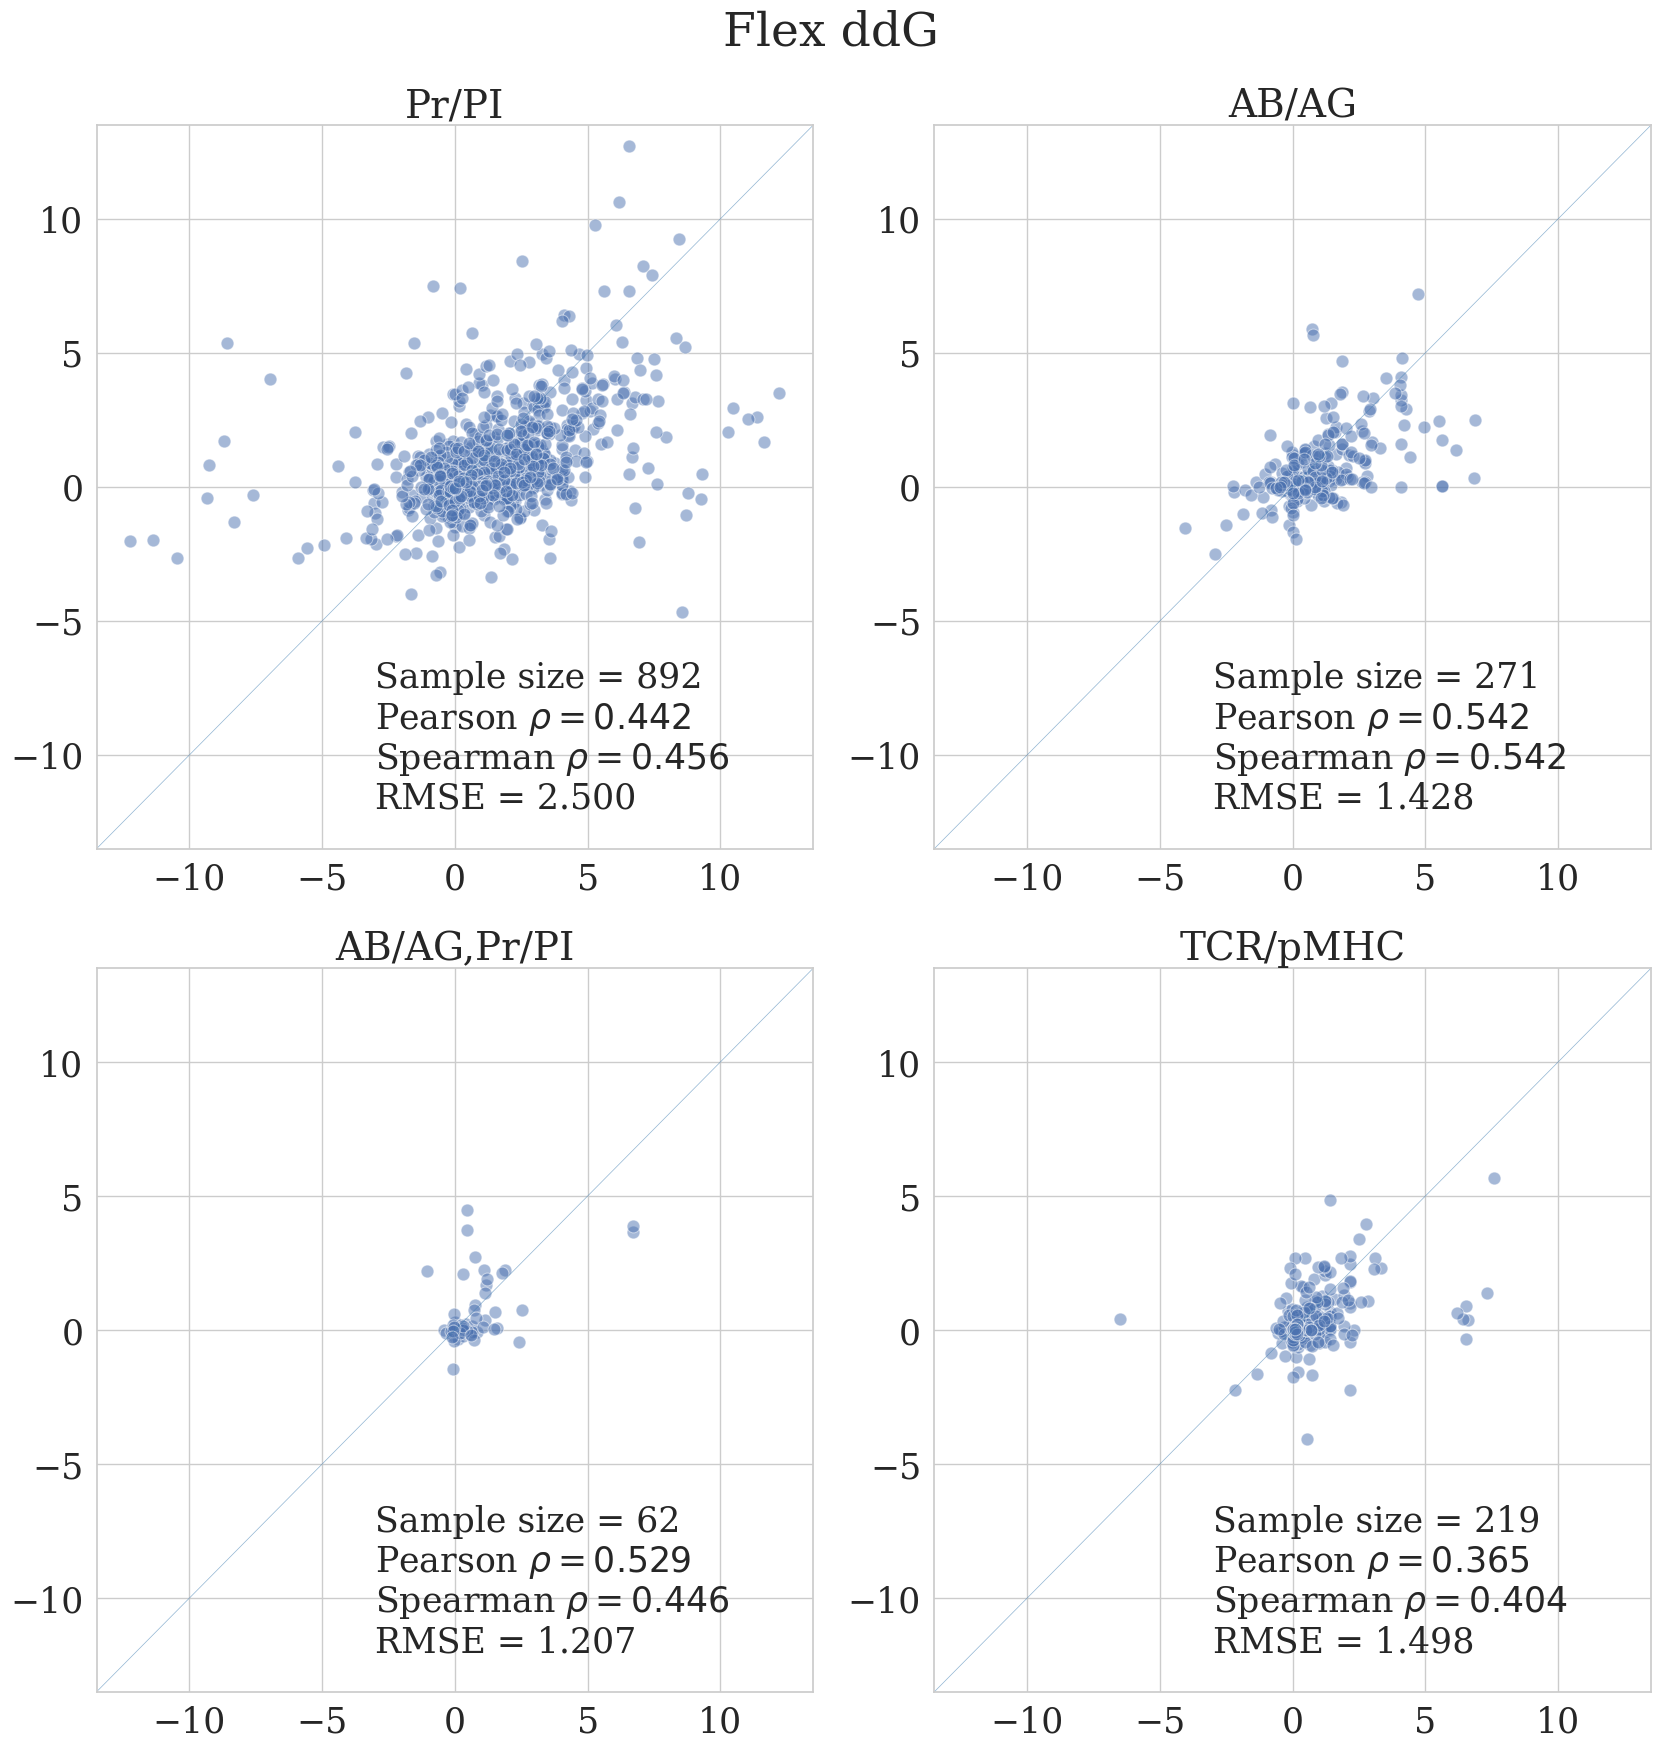

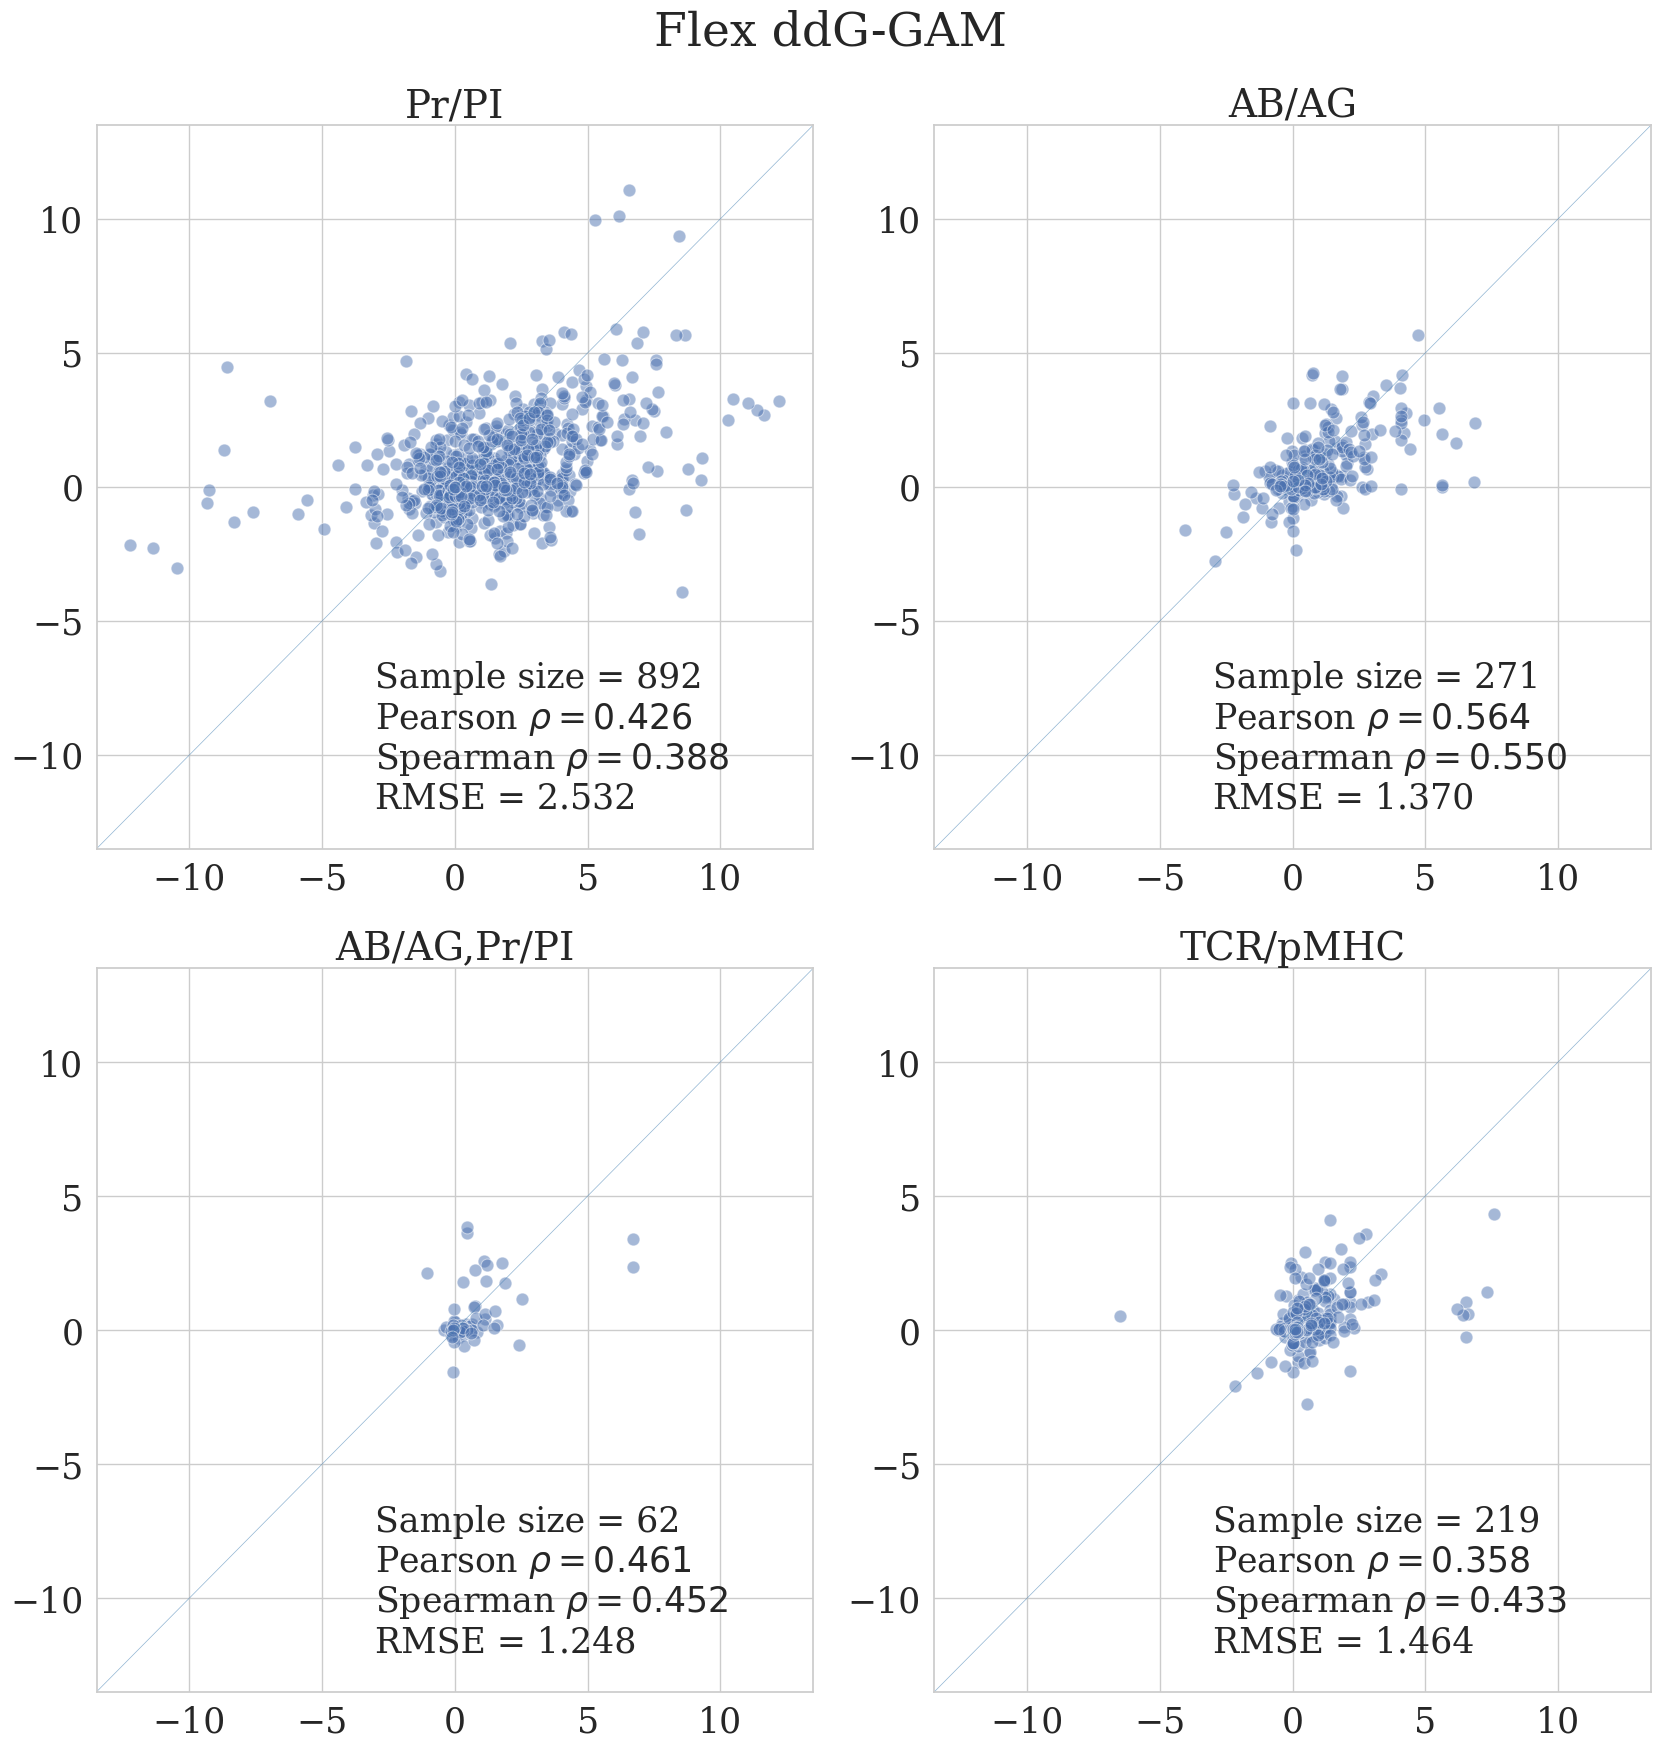

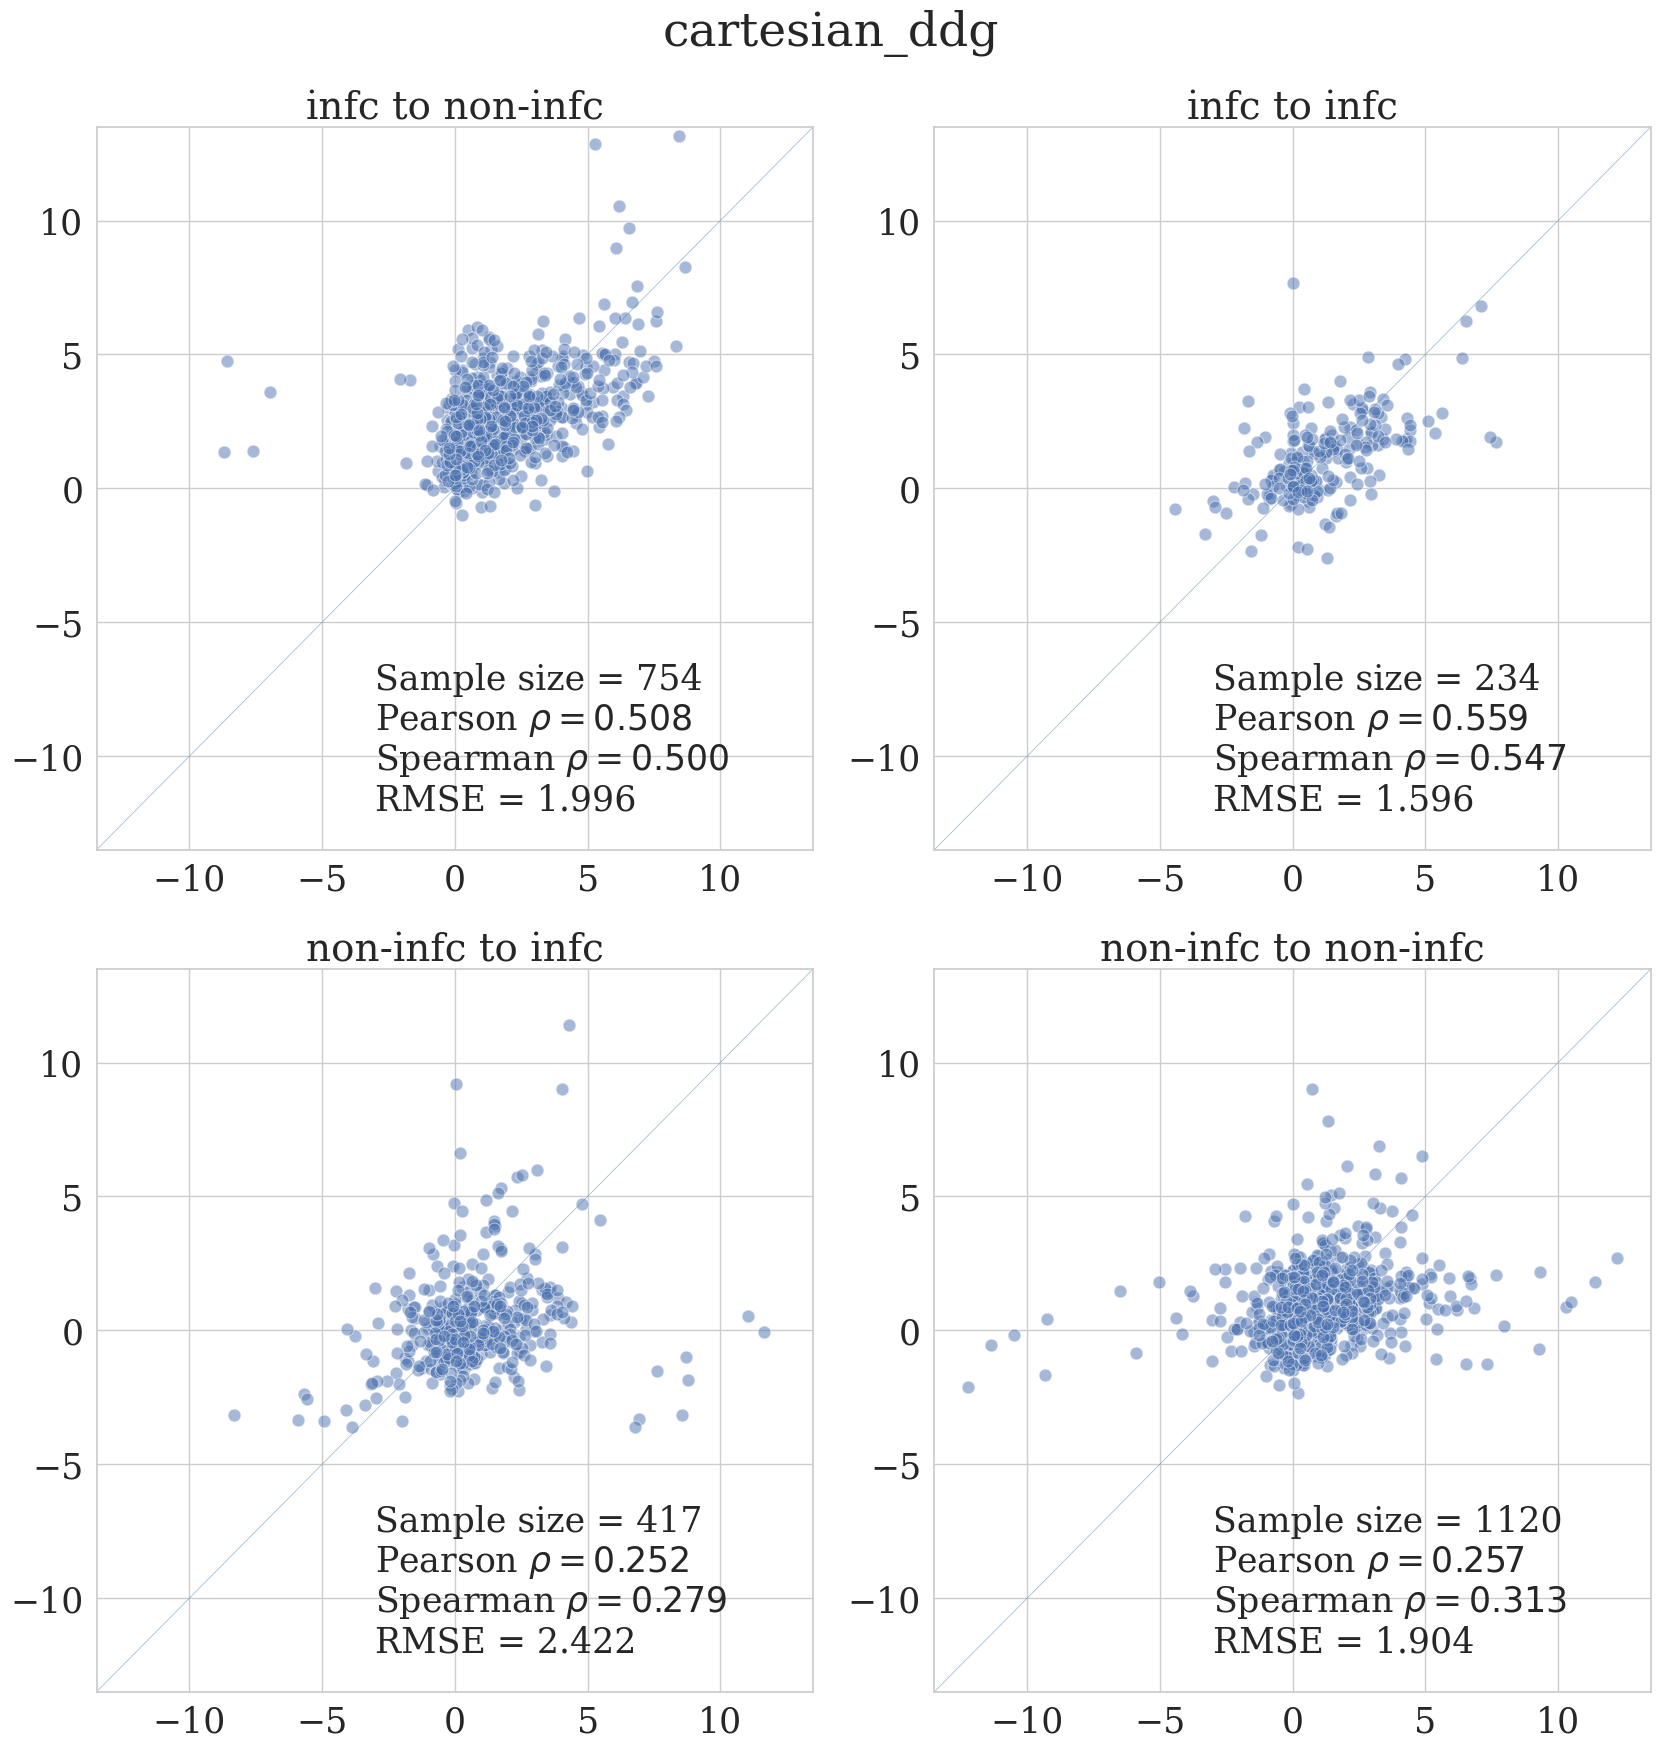

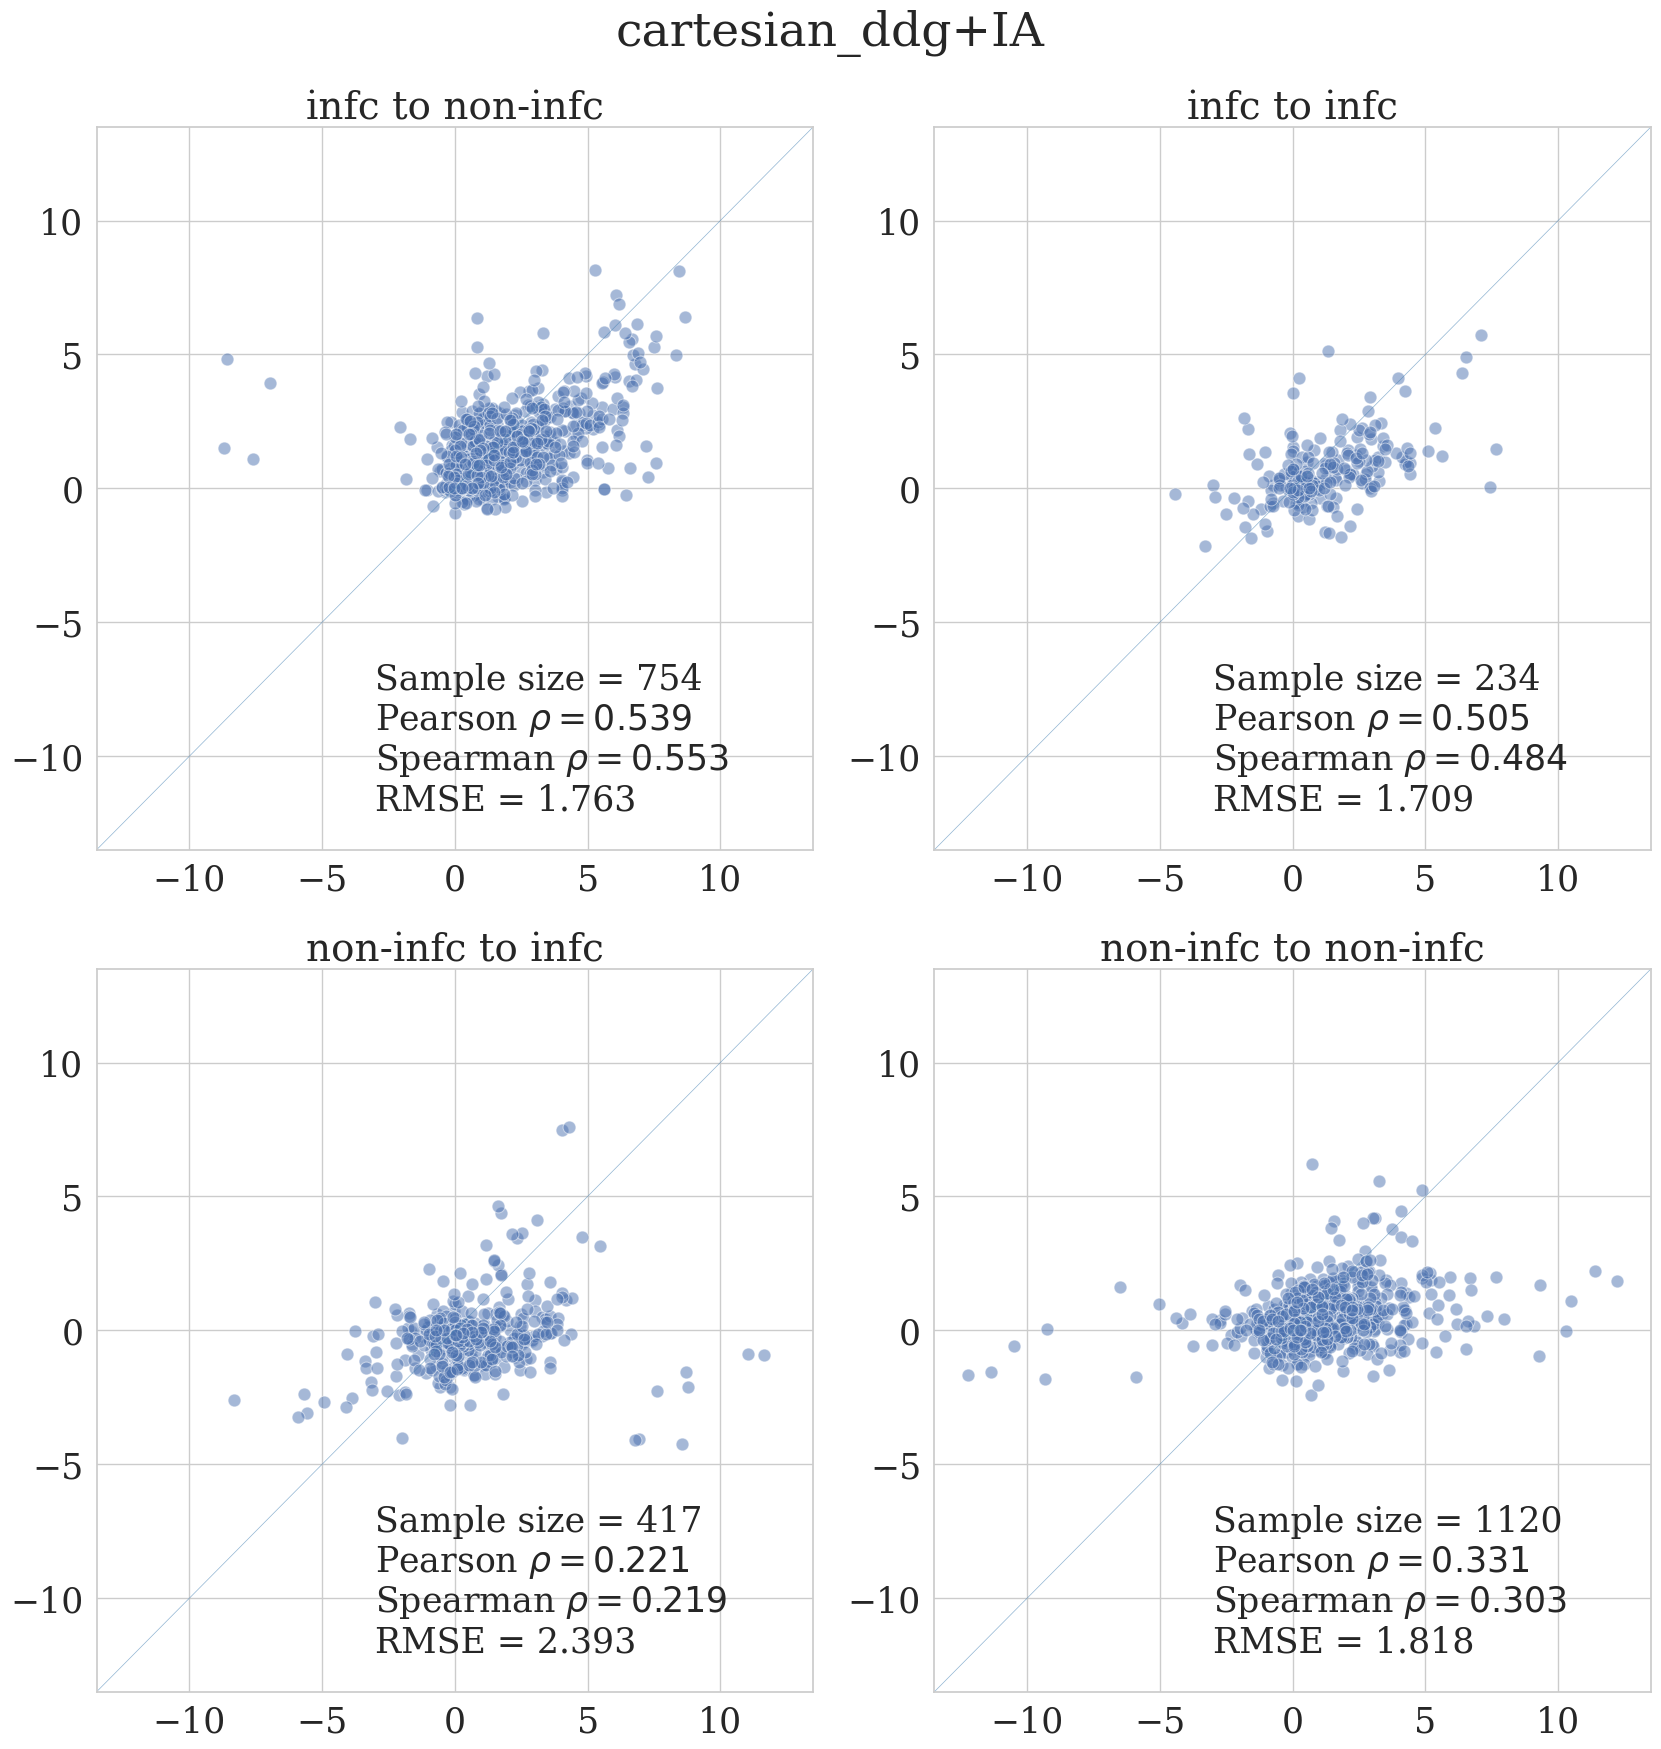

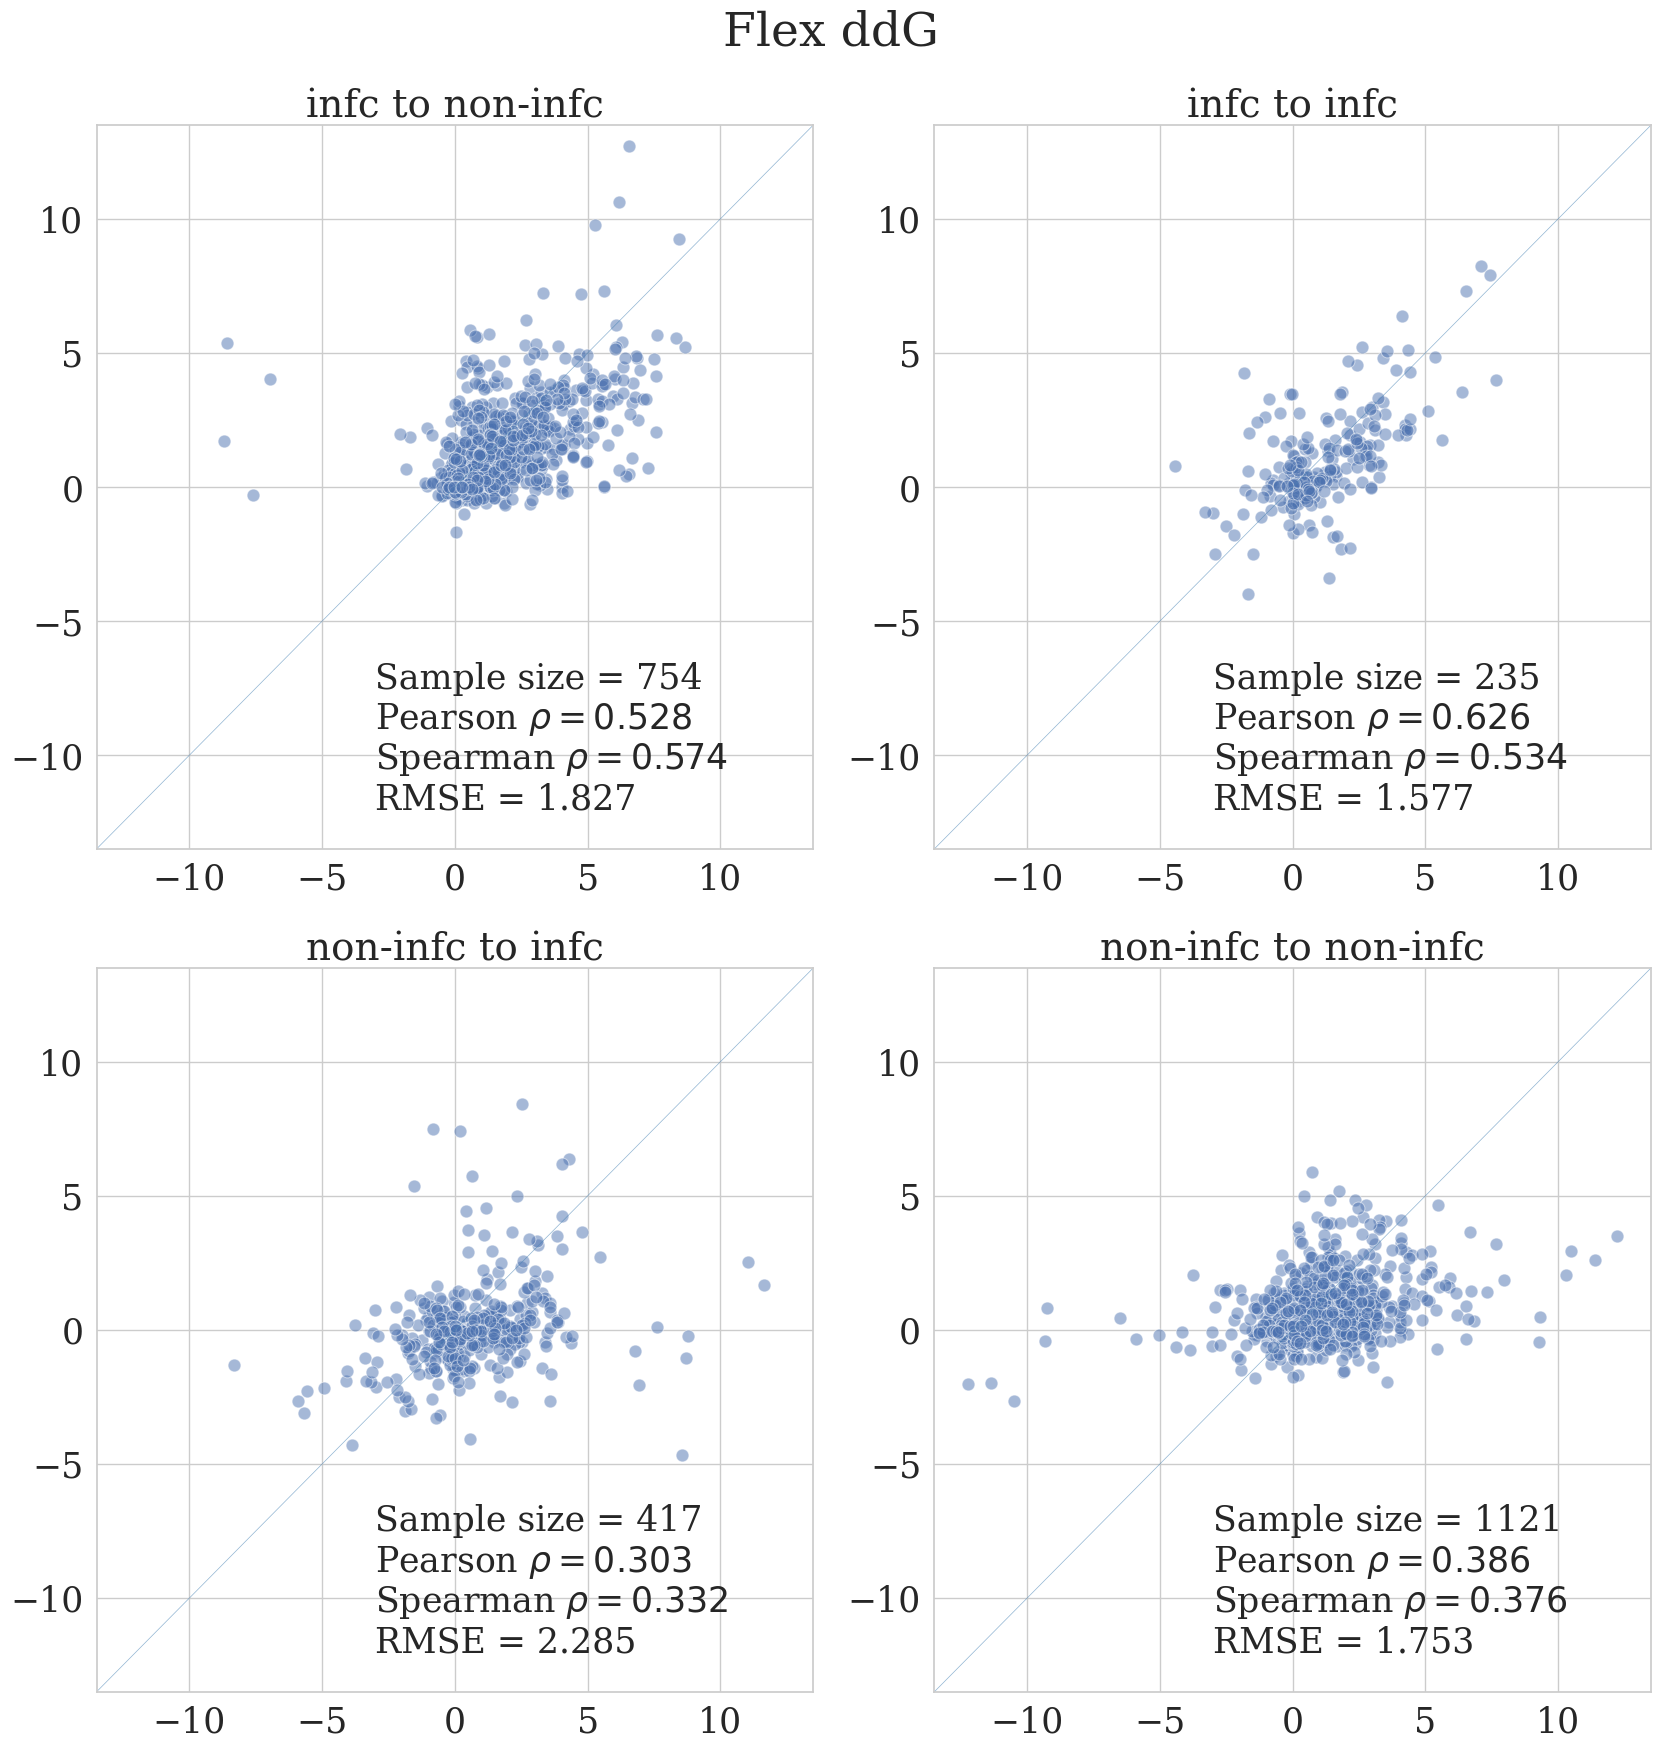

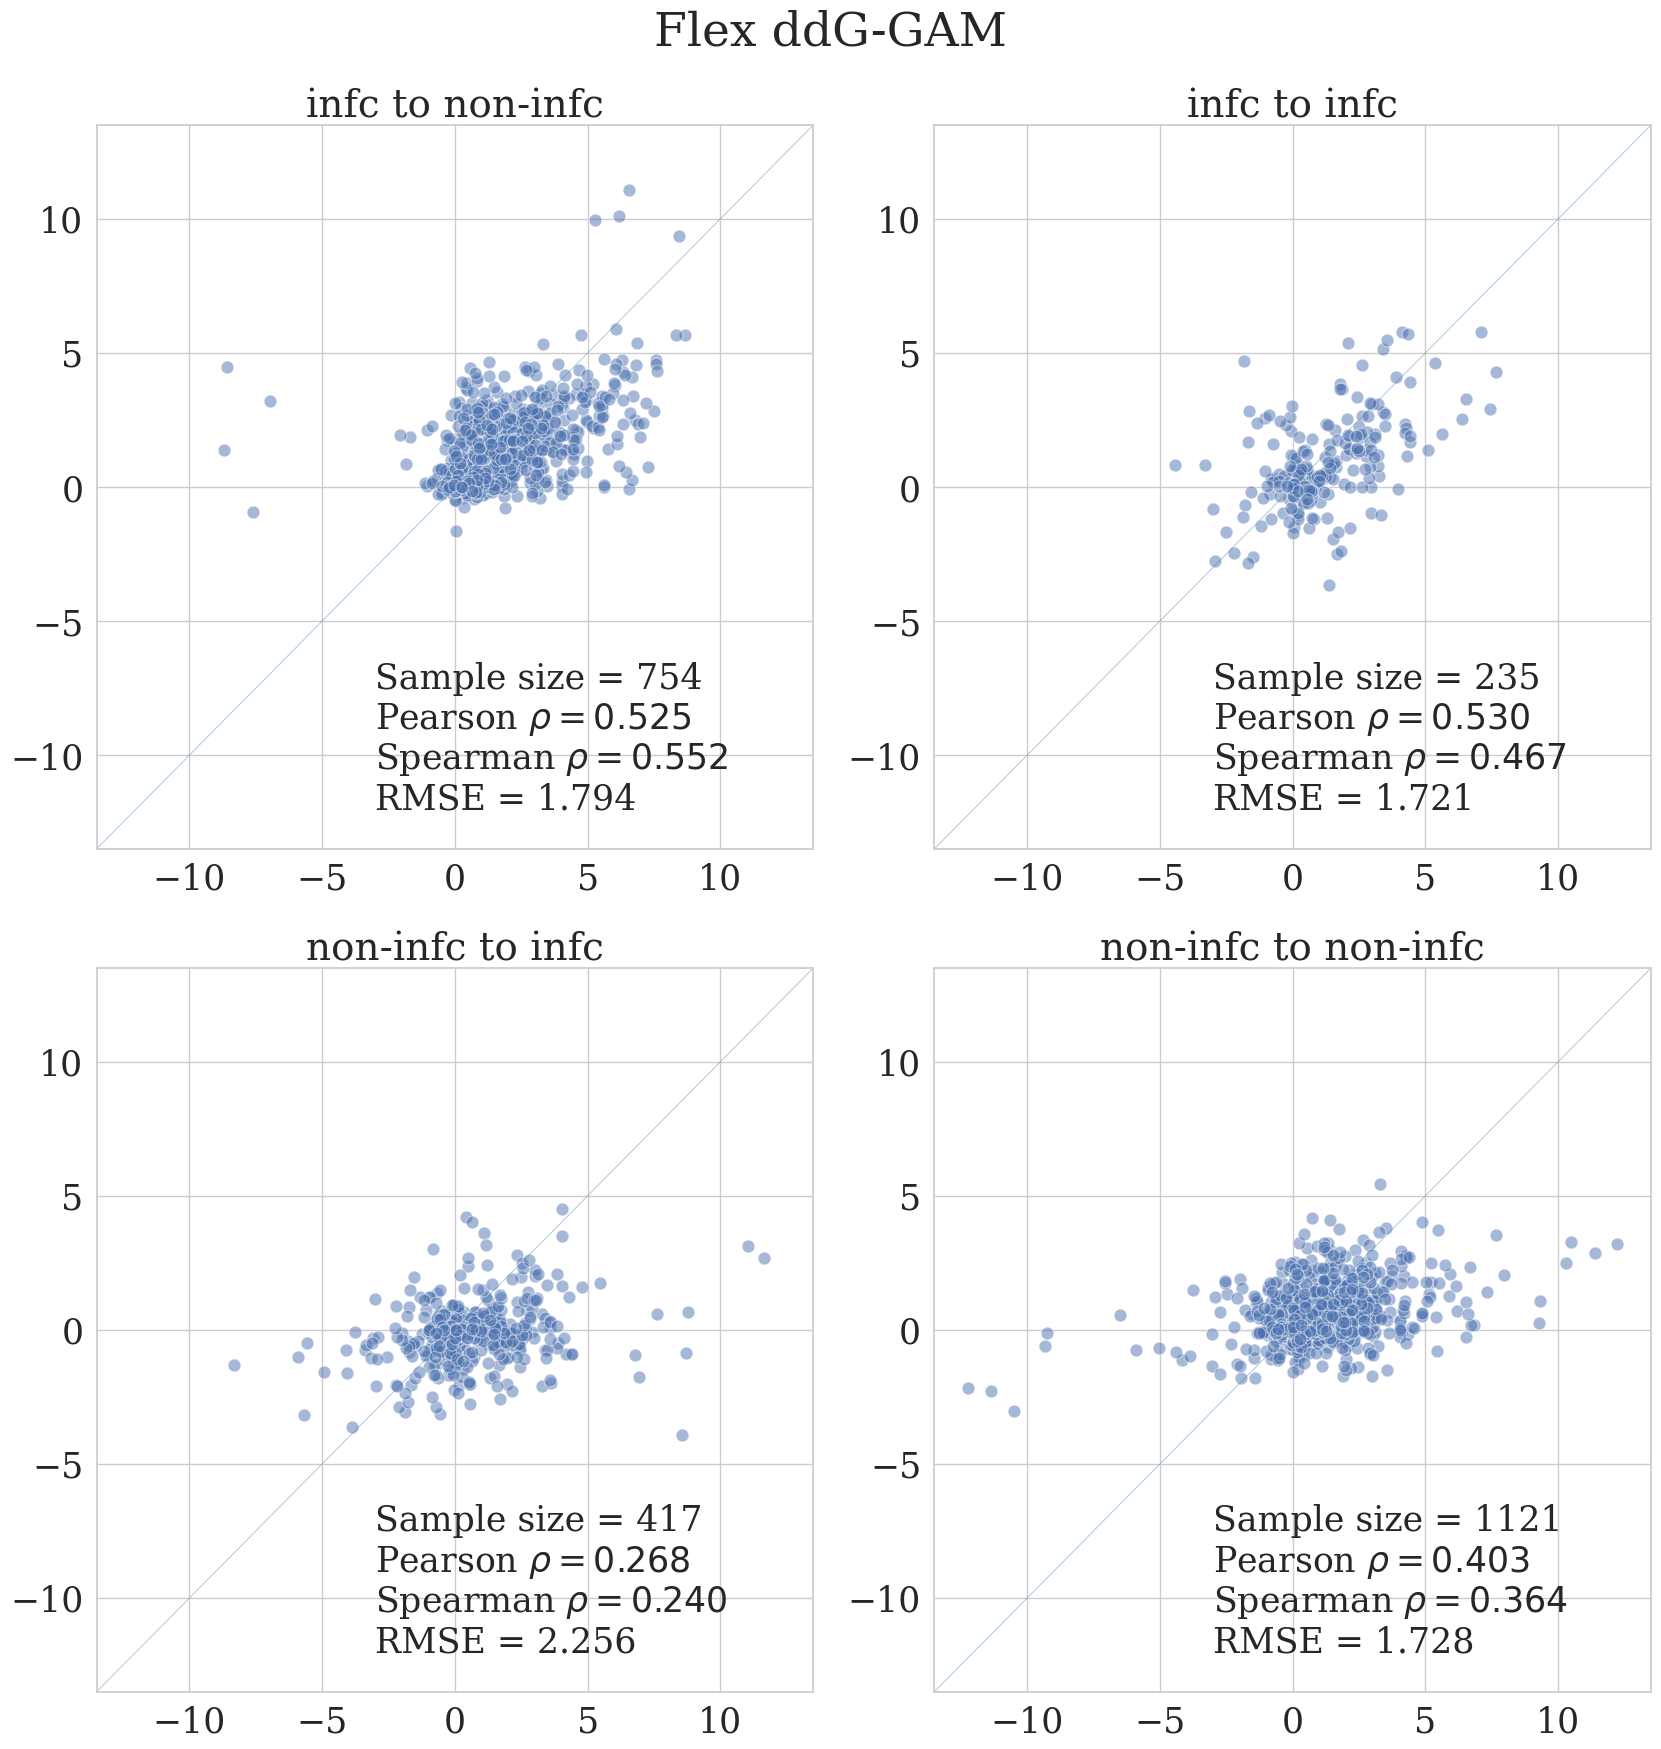

In [133]:
methods_suppl_plot = {'mean_ddG': 'cartesian_ddg',
                      'mean_ddG_infc': 'cartesian_ddg+IA',
                      'flex_ddg': 'Flex ddG',
                      'flex_ddg_gam': 'Flex ddG-GAM'}
# sep_feature = {'small-to-large': (1, 2, 18, 10),
#                'Hold_out_type': (2, 2, 19, 20),
#                'type_of_change_infc': (2, 2, 19, 20)}
sep_feature = {'small-to-large': (1, 2, 16.2, 9),
               'Hold_out_type': (2, 2, 17.1, 18),
               'type_of_change_infc': (2, 2, 17.1, 18)}
df = S2536_sub_flex.copy()

for sf in sep_feature.keys():
    dim_set = sep_feature[sf]
    for meth in methods_suppl_plot.keys():
        fig, axs = plt.subplots(dim_set[0], dim_set[1], figsize=(dim_set[2], dim_set[3]))  # 3 rows, 1 column
        axs = axs.flatten()
        plt.setp(axs, xlim=(-13.5, 13.5), ylim=(-13.5, 13.5))
        # Loop through the data and axes, and plot each scatter plot
        for ax, sf_unique in zip(axs, df[sf].dropna().unique()):
            subset_na = df.loc[df[sf]==sf_unique]
            subset = subset_na.dropna(subset=[meth]).copy()
            sns.scatterplot(data=subset, x='DDGb',
                               y=meth,
                               alpha=0.5, s=85,
                               ax=ax)
            
            ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
        
            ax.annotate(f'Sample size = {len(subset)}', xy=(-3, -7.5), fontsize = 25)
            r, p = stats.pearsonr(subset['DDGb'], subset[meth])
            ax.annotate(f'Pearson $\\rho = {r:.3f}$', xy=(-3, -9), fontsize = 25)
            r, p = stats.spearmanr(subset['DDGb'], subset[meth])
            ax.annotate(f'Spearman $\\rho = {r:.3f}$', xy=(-3, -10.5), fontsize = 25)
            rmse = sqrt(mean_squared_error(subset['DDGb'], subset[meth]))
            ax.annotate(f'RMSE = {rmse:.3f}', xy=(-3, -12), fontsize = 25)
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.set_title(f'{sf_unique}', fontsize = 28)
            #sns.move_legend(ax, "upper left")
            
        #axs[1].set_xlabel("Experimental binding ddG", fontsize = 32)
        #axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
        fig.suptitle(f'{methods_suppl_plot[meth]}', fontsize=34)
        # plt.tight_layout(rect=[0.05, 0.05, 1, 1])
        plt.tight_layout()
        
        plt.savefig(f'Figures/s2536_suppl/{sf}_{meth}.pdf', format='pdf')

In [20]:
median_dict = dict()
for meth in ['mean_ddG', 'mean_ddG_infc', 'flex_ddg', 'flex_ddg_gam', 'DDGb']:
    print(meth)
    print('min: ', S2536_sub_flex[meth].min())
    print('max: ', S2536_sub_flex[meth].max())
    print('mean: ', S2536_sub_flex[meth].mean())
    print('median: ', S2536_sub_flex[meth].median())
    
    median_dict[meth] = S2536_sub_flex[meth].median()

mean_ddG
min:  -3.609655172413897
max:  13.157816091953968
mean:  1.3065824513485853
median:  1.0639080459769168
mean_ddG_infc
min:  -4.233776173432385
max:  8.139597097422604
mean:  0.5601201959844292
median:  0.2123645608906205
flex_ddg
min:  -4.65945
max:  12.73611
mean:  0.7522289631974673
median:  0.28918
flex_ddg_gam
min:  -3.934067143513864
max:  11.072494910792344
mean:  0.6764728292813904
median:  0.3054846849247168
DDGb
min:  -12.222
max:  12.222
mean:  1.1071707413249212
median:  0.6904999999999999


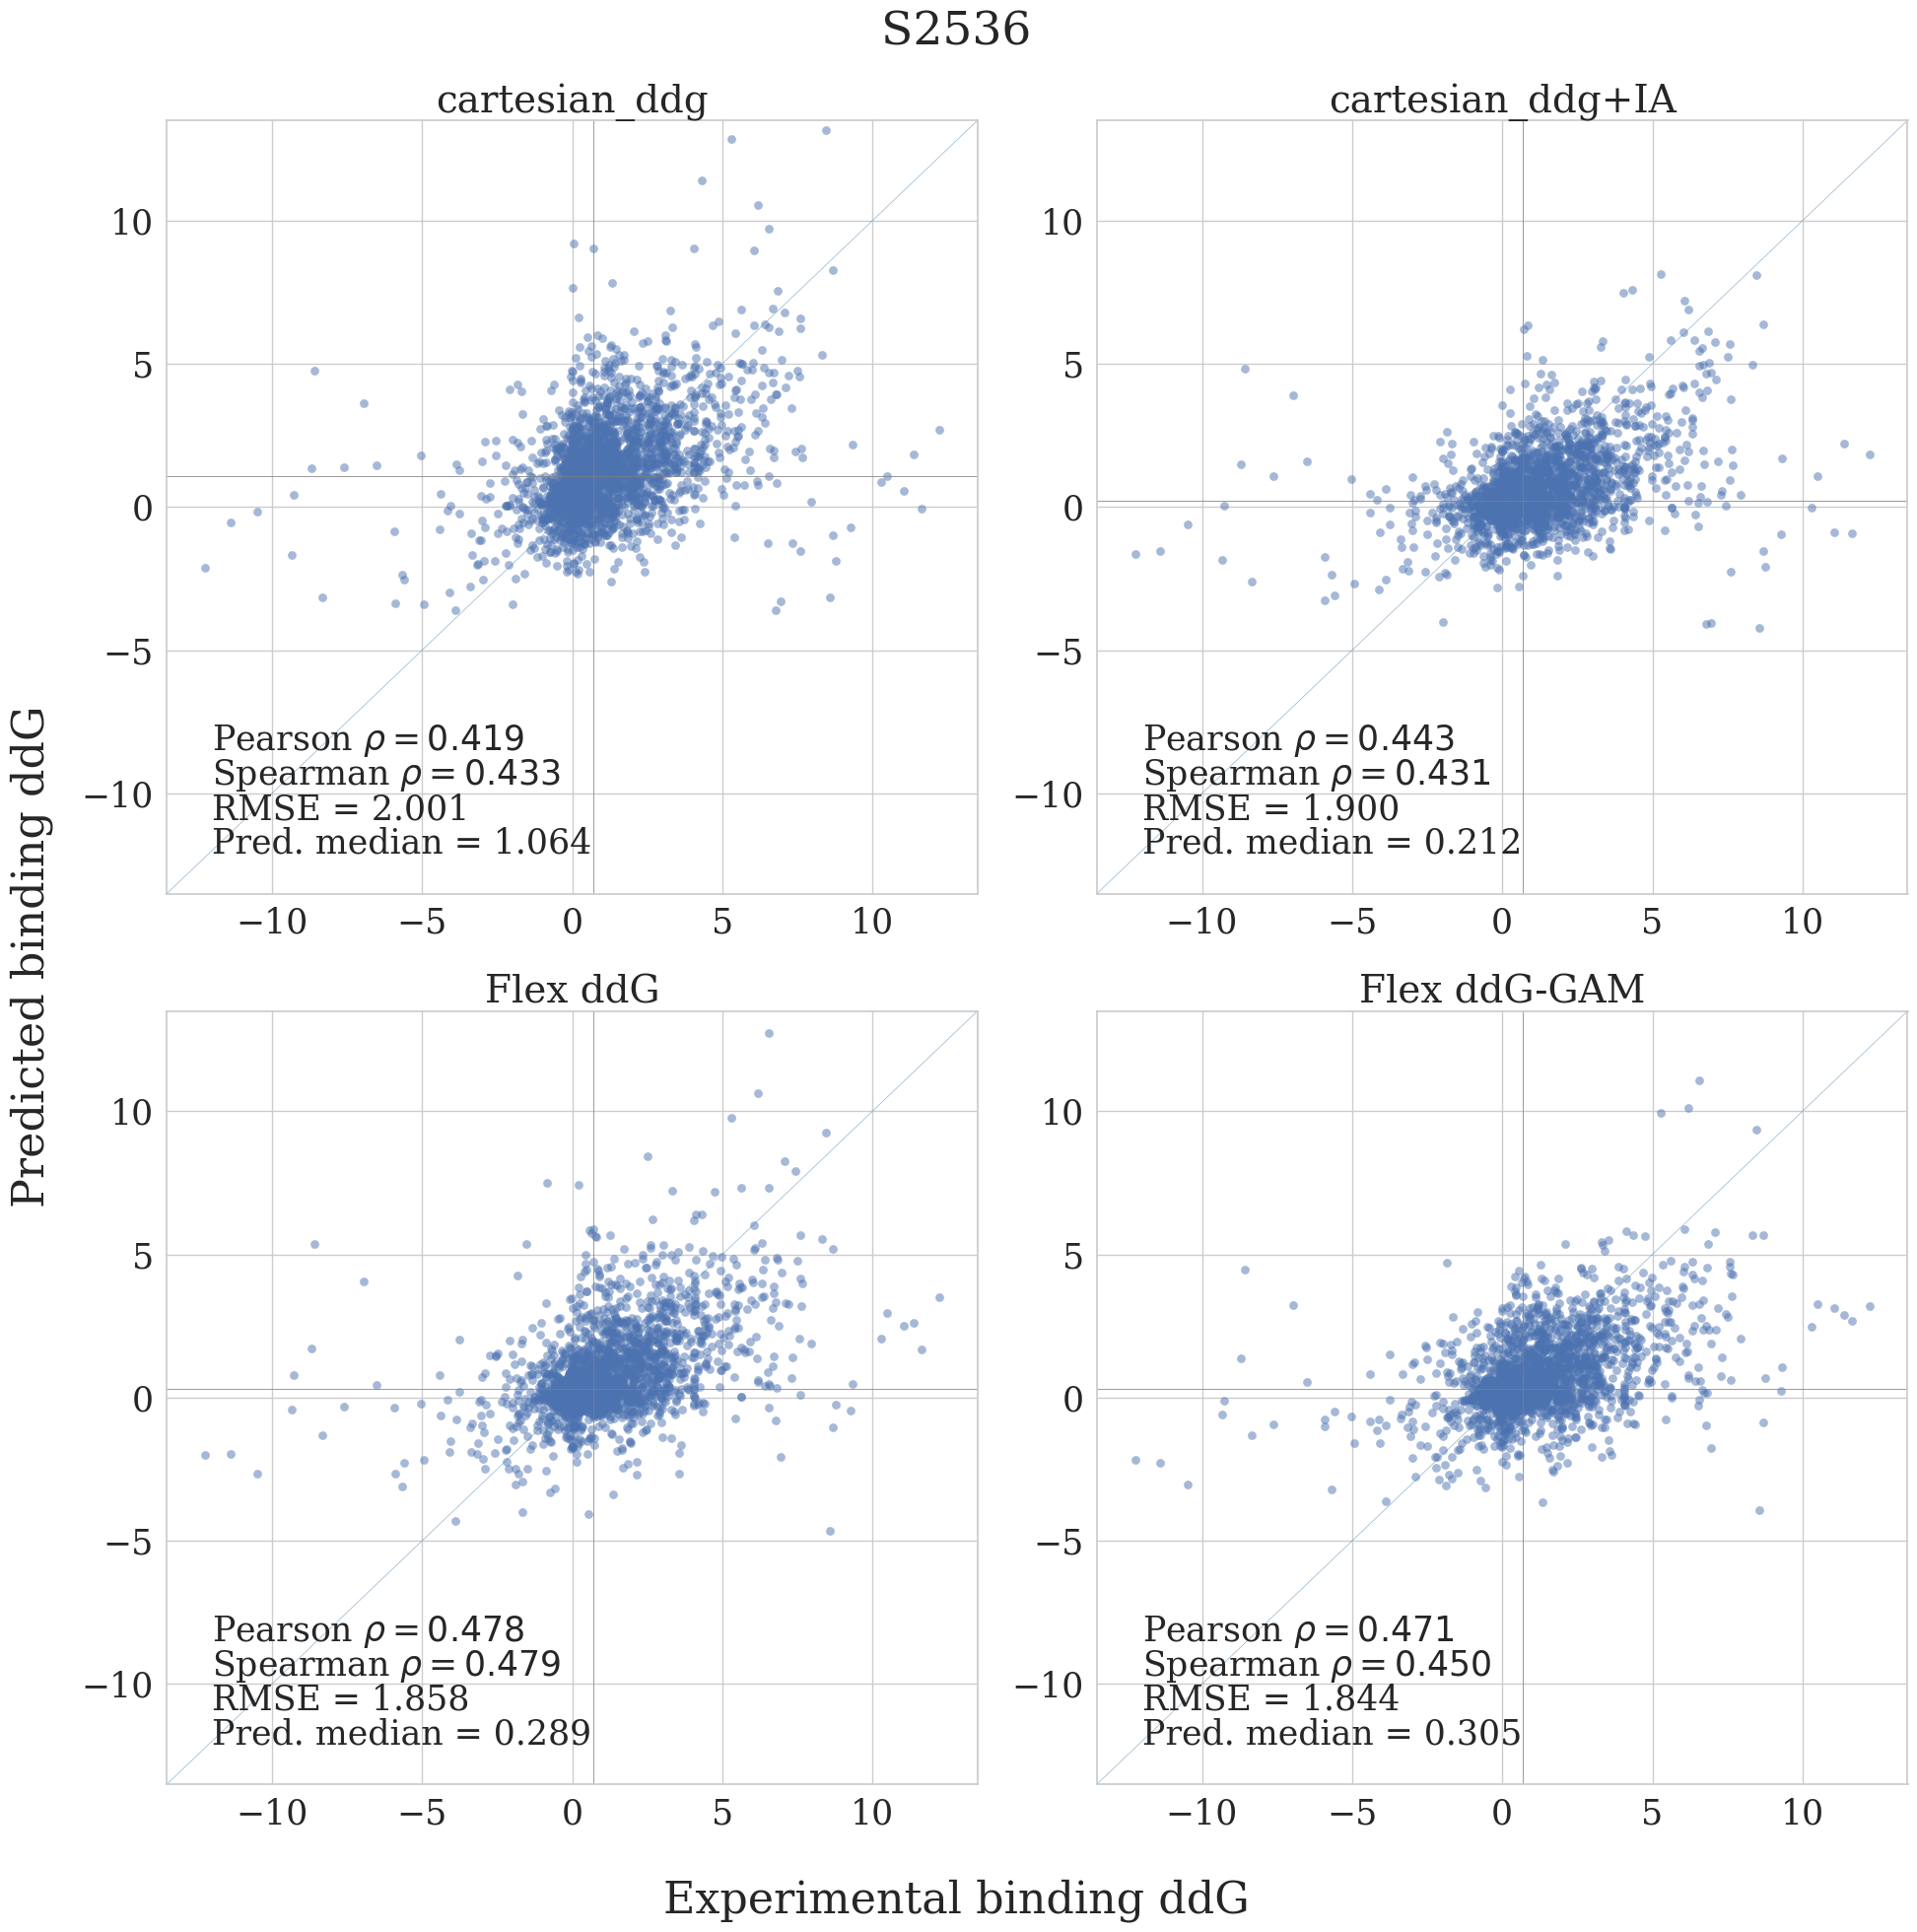

In [44]:
methods_suppl_plot = {'mean_ddG': 'cartesian_ddg',
                      'mean_ddG_infc': 'cartesian_ddg+IA',
                      'flex_ddg': 'Flex ddG',
                      'flex_ddg_gam': 'Flex ddG-GAM'}
df = S2536_sub_flex.copy()

fig, axs = plt.subplots(2, 2, figsize=(20, 20))  # 3 rows, 1 column
axs = axs.flatten()
plt.setp(axs, xlim=(-13.5, 13.5), ylim=(-13.5, 13.5))
    
# Loop through the data and axes, and plot each scatter plot
for ax, meth in zip(axs, methods_suppl_plot.keys()):
    subset = df.dropna(subset=[meth]).copy()
    sns.scatterplot(data=subset, x='DDGb',
                       y=meth,
                       alpha=0.5, s=40, linewidth = 0,
                       ax=ax)
    
    ax.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    ax.axhline(median_dict[meth], -15, 15, color='gray', ls='-', lw=0.7, alpha=0.8)
    ax.axvline(median_dict['DDGb'], -15, 15, color='gray', ls='-', lw=0.7, alpha=0.8)

    r, p = stats.pearsonr(subset['DDGb'], subset[meth])
    ax.annotate(f'Pearson $\\rho = {r:.3f}$', xy=(-12, -8.5), fontsize = 25)
    r, p = stats.spearmanr(subset['DDGb'], subset[meth])
    ax.annotate(f'Spearman $\\rho = {r:.3f}$', xy=(-12, -9.7), fontsize = 25)
    rmse = sqrt(mean_squared_error(subset['DDGb'], subset[meth]))
    ax.annotate(f'RMSE = {rmse:.3f}', xy=(-12, -10.9), fontsize = 25)
    ax.annotate(f'Pred. median = {median_dict[meth]:.3f}', xy=(-12, -12.1), fontsize = 25)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(f'{methods_suppl_plot[meth]}', fontsize = 28)
    #sns.move_legend(ax, "upper left")
    
# axs[1].set_xlabel("Experimental binding ddG", fontsize = 32)
# axs[0].set_ylabel("Predicted binding ddG", fontsize = 32)
fig.suptitle('S2536', fontsize=34)
# Set the single X and Y labels for the entire figure
fig.supxlabel("Experimental binding ddG", fontsize = 32)
fig.supylabel("Predicted binding ddG", fontsize = 32)
# plt.tight_layout(rect=[0.05, 0.05, 1, 1])
plt.tight_layout()

plt.savefig(f'Figures/S2536_carts_flexs.pdf', format='pdf')

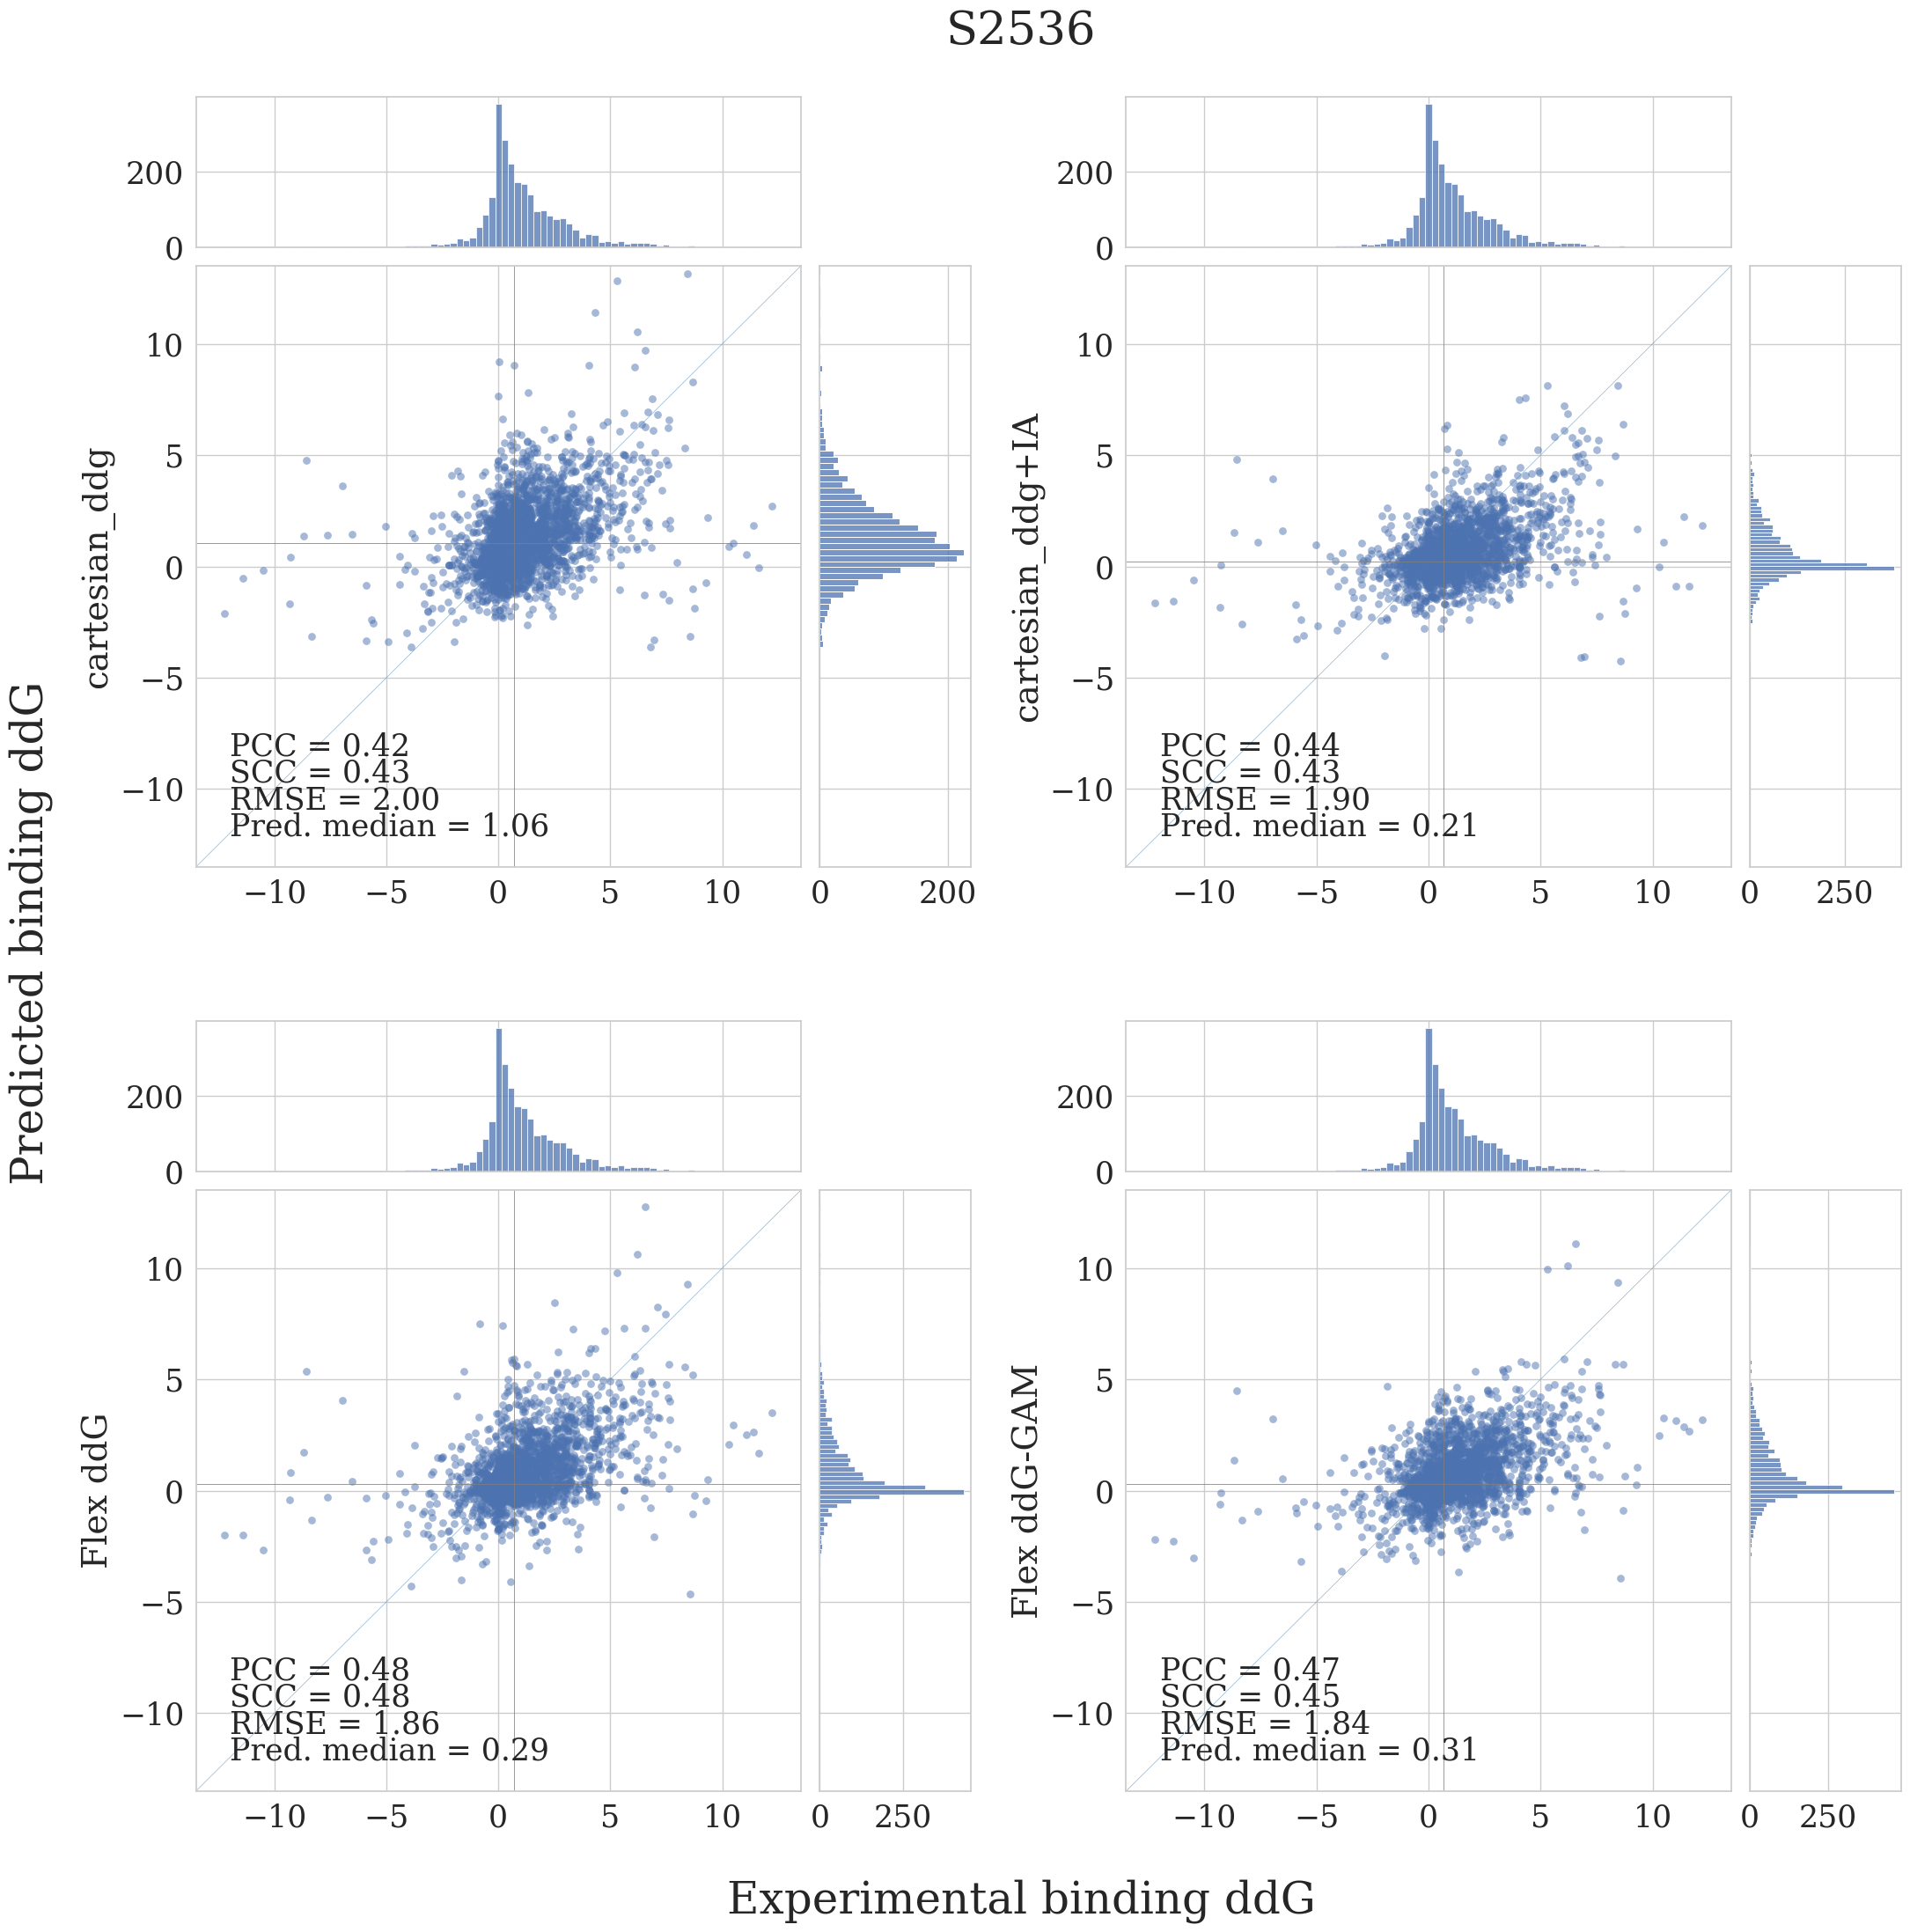

In [17]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt

methods_suppl_plot = {'mean_ddG': 'cartesian_ddg',
                      'mean_ddG_infc': 'cartesian_ddg+IA',
                      'flex_ddg': 'Flex ddG',
                      'flex_ddg_gam': 'Flex ddG-GAM'}
df = S2536_sub_flex.copy()

# Create the main figure
fig = plt.figure(figsize=(25, 25))

# Create a 2x2 GridSpec for the overall layout
outer_grid = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.2)

# Loop through the methods and the grid locations
for i, meth in enumerate(methods_suppl_plot.keys()):
    # Create a nested GridSpec for each plot (scatter + marginals)
    # Define ratios to make the central plot larger than the marginals
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid[i],
                                                  width_ratios=(4, 1), height_ratios=(1, 4),
                                                  wspace=0.05, hspace=0.05)

    # Create axes from the inner grid
    ax_scatter = fig.add_subplot(inner_grid[1, 0])
    ax_histx = fig.add_subplot(inner_grid[0, 0], sharex=ax_scatter)
    ax_histy = fig.add_subplot(inner_grid[1, 1], sharey=ax_scatter)

    # Remove tick labels from the marginal histograms for a cleaner look
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # --- Plotting Section ---
    subset = df.dropna(subset=[meth]).copy()

    # Main scatter plot (on the central axis)
    sns.scatterplot(data=subset, x='DDGb', y=meth,
                    alpha=0.5, s=40, linewidth=0,
                    ax=ax_scatter)

    # Marginal histograms
    sns.histplot(data=subset, x='DDGb', ax=ax_histx, kde=False)
    sns.histplot(data=subset, y=meth, ax=ax_histy, kde=False)
    
    # Remove the "Count" labels from the histograms
    ax_histx.set_ylabel('')
    ax_histy.set_xlabel('')

    # --- Original Formatting and Annotation ---
    # Set shared limits for the scatter plot
    ax_scatter.set_xlim(-13.5, 13.5)
    ax_scatter.set_ylim(-13.5, 13.5)
    
    # Add diagonal and median lines to the scatter plot
    ax_scatter.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    ax_scatter.axhline(subset[meth].median(), color='gray', ls='-', lw=0.7, alpha=0.8)
    ax_scatter.axvline(subset['DDGb'].median(), color='gray', ls='-', lw=0.7, alpha=0.8)

    # Add statistical annotations to the scatter plot
    r, _ = stats.pearsonr(subset['DDGb'], subset[meth])
    ax_scatter.annotate(f'PCC = {r:.2f}', xy=(-12, -8.5), fontsize=25)
    r, _ = stats.spearmanr(subset['DDGb'], subset[meth])
    ax_scatter.annotate(f'SCC = {r:.2f}', xy=(-12, -9.7), fontsize=25)
    rmse = sqrt(mean_squared_error(subset['DDGb'], subset[meth]))
    ax_scatter.annotate(f'RMSE = {rmse:.2f}', xy=(-12, -10.9), fontsize=25)
    ax_scatter.annotate(f'Pred. median = {subset[meth].median():.2f}', xy=(-12, -12.1), fontsize=25)
    
    # Set individual plot titles and remove inner labels
    ax_scatter.set_ylabel(f'{methods_suppl_plot[meth]}', fontsize=28)
    ax_scatter.set_xlabel("")
    # ax_scatter.set_title(f'{methods_suppl_plot[meth]}', fontsize=28)

# --- Final Figure-Level Adjustments ---
fig.suptitle('S2536', fontsize=38, y=0.92)

# Set the single X and Y labels for the entire figure
fig.supxlabel("Experimental binding ddG", fontsize=36, y=0.05)
fig.supylabel("Predicted binding ddG", fontsize=36, x=0.04)

# # Adjust layout to prevent labels from overlapping
#plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])

plt.savefig(f'Figures/S2536_carts_flexs_marginals.pdf', format='pdf')
# plt.show()

In [ ]:
S2536_sub_flex['region'].value_counts()

Text(0.04, 0.5, 'Predicted binding ddG')

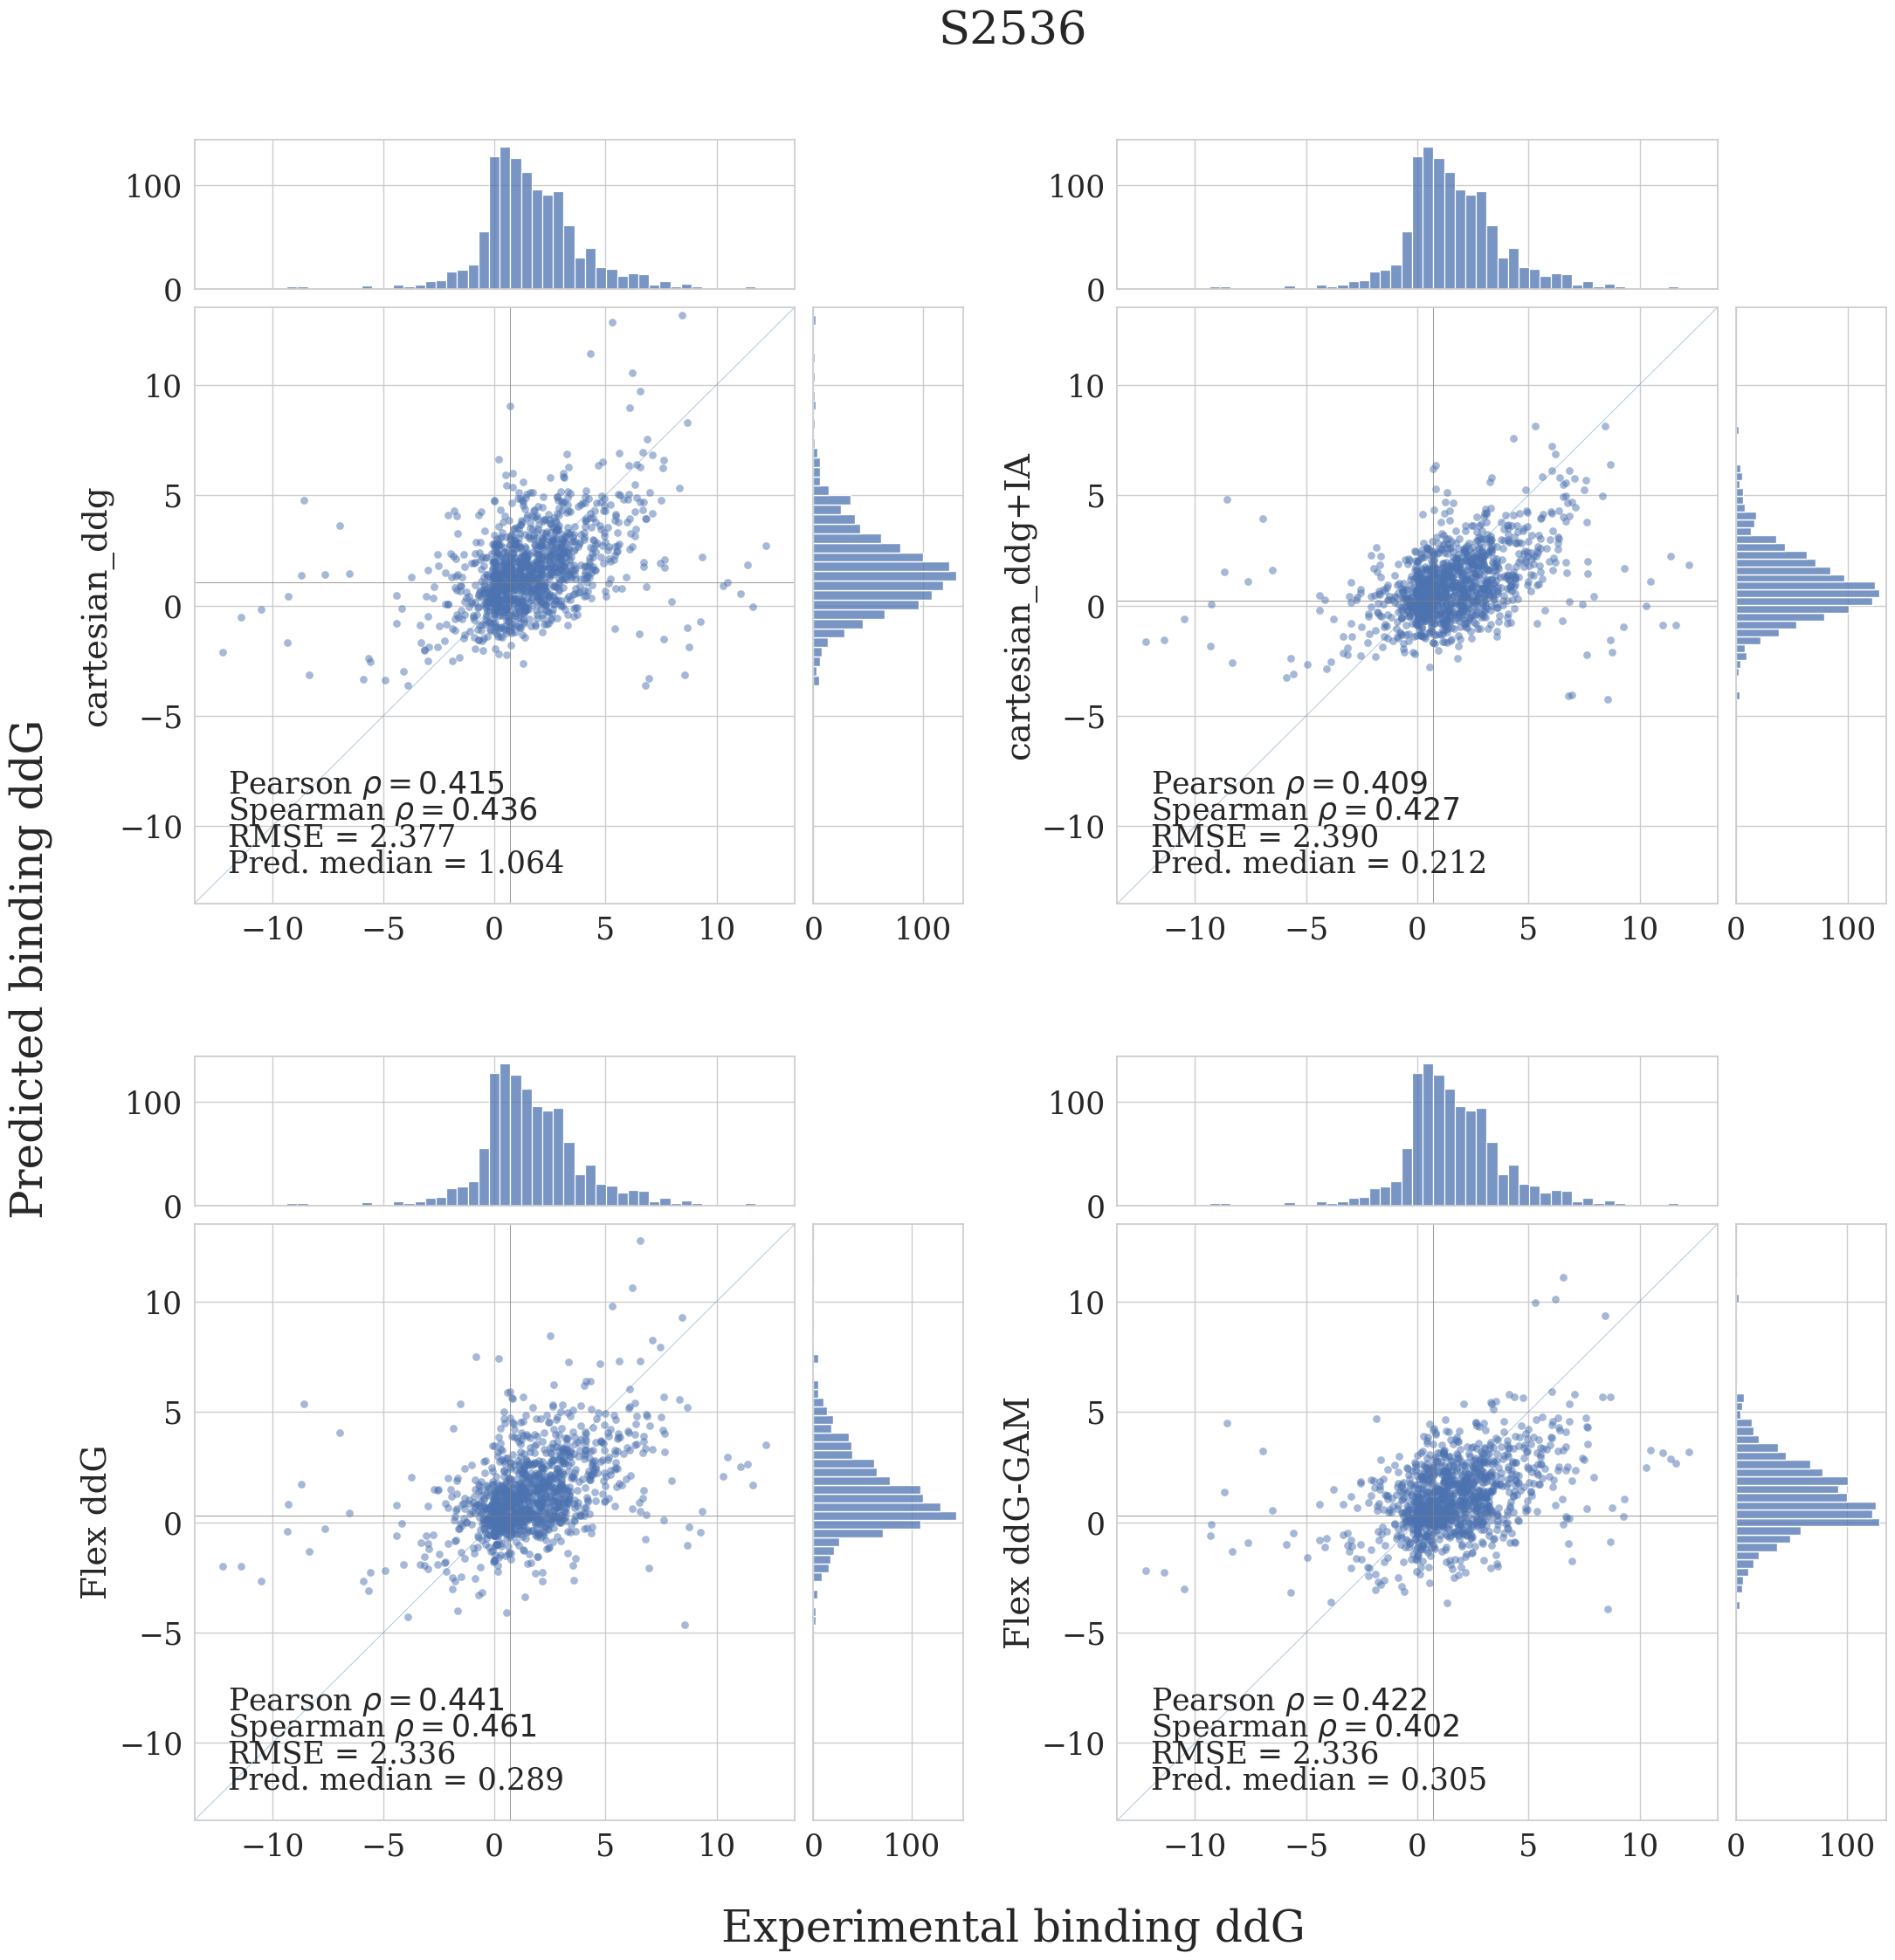

In [30]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt

methods_suppl_plot = {'mean_ddG': 'cartesian_ddg',
                      'mean_ddG_infc': 'cartesian_ddg+IA',
                      'flex_ddg': 'Flex ddG',
                      'flex_ddg_gam': 'Flex ddG-GAM'}
df = S2536_sub_flex.loc[S2536_sub_flex['region']=='Core'].copy()

# Create the main figure
fig = plt.figure(figsize=(25, 25))

# Create a 2x2 GridSpec for the overall layout
outer_grid = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.2)

# Loop through the methods and the grid locations
for i, meth in enumerate(methods_suppl_plot.keys()):
    # Create a nested GridSpec for each plot (scatter + marginals)
    # Define ratios to make the central plot larger than the marginals
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid[i],
                                                  width_ratios=(4, 1), height_ratios=(1, 4),
                                                  wspace=0.05, hspace=0.05)

    # Create axes from the inner grid
    ax_scatter = fig.add_subplot(inner_grid[1, 0])
    ax_histx = fig.add_subplot(inner_grid[0, 0], sharex=ax_scatter)
    ax_histy = fig.add_subplot(inner_grid[1, 1], sharey=ax_scatter)

    # Remove tick labels from the marginal histograms for a cleaner look
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # --- Plotting Section ---
    subset = df.dropna(subset=[meth]).copy()

    # Main scatter plot (on the central axis)
    sns.scatterplot(data=subset, x='DDGb', y=meth,
                    alpha=0.5, s=40, linewidth=0,
                    ax=ax_scatter)

    # Marginal histograms
    sns.histplot(data=subset, x='DDGb', ax=ax_histx, kde=False)
    sns.histplot(data=subset, y=meth, ax=ax_histy, kde=False)
    
    # Remove the "Count" labels from the histograms
    ax_histx.set_ylabel('')
    ax_histy.set_xlabel('')

    # --- Original Formatting and Annotation ---
    # Set shared limits for the scatter plot
    ax_scatter.set_xlim(-13.5, 13.5)
    ax_scatter.set_ylim(-13.5, 13.5)
    
    # Add diagonal and median lines to the scatter plot
    ax_scatter.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    ax_scatter.axhline(median_dict[meth], color='gray', ls='-', lw=0.7, alpha=0.8)
    ax_scatter.axvline(median_dict['DDGb'], color='gray', ls='-', lw=0.7, alpha=0.8)

    # Add statistical annotations to the scatter plot
    r, _ = stats.pearsonr(subset['DDGb'], subset[meth])
    ax_scatter.annotate(f'Pearson $\\rho = {r:.3f}$', xy=(-12, -8.5), fontsize=25)
    r, _ = stats.spearmanr(subset['DDGb'], subset[meth])
    ax_scatter.annotate(f'Spearman $\\rho = {r:.3f}$', xy=(-12, -9.7), fontsize=25)
    rmse = sqrt(mean_squared_error(subset['DDGb'], subset[meth]))
    ax_scatter.annotate(f'RMSE = {rmse:.3f}', xy=(-12, -10.9), fontsize=25)
    ax_scatter.annotate(f'Pred. median = {median_dict[meth]:.3f}', xy=(-12, -12.1), fontsize=25)
    
    # Set individual plot titles and remove inner labels
    ax_scatter.set_ylabel(f'{methods_suppl_plot[meth]}', fontsize=28)
    ax_scatter.set_xlabel("")
    # ax_scatter.set_title(f'{methods_suppl_plot[meth]}', fontsize=28)

# --- Final Figure-Level Adjustments ---
fig.suptitle('S2536', fontsize=38, y=0.94)

# Set the single X and Y labels for the entire figure
fig.supxlabel("Experimental binding ddG", fontsize=36, y=0.05)
fig.supylabel("Predicted binding ddG", fontsize=36, x=0.04)

# # Adjust layout to prevent labels from overlapping
#plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])

#plt.savefig(f'Figures/S2536_carts_flexs_marginals.pdf', format='pdf')
# plt.show()

Text(0.04, 0.5, 'Predicted binding ddG')

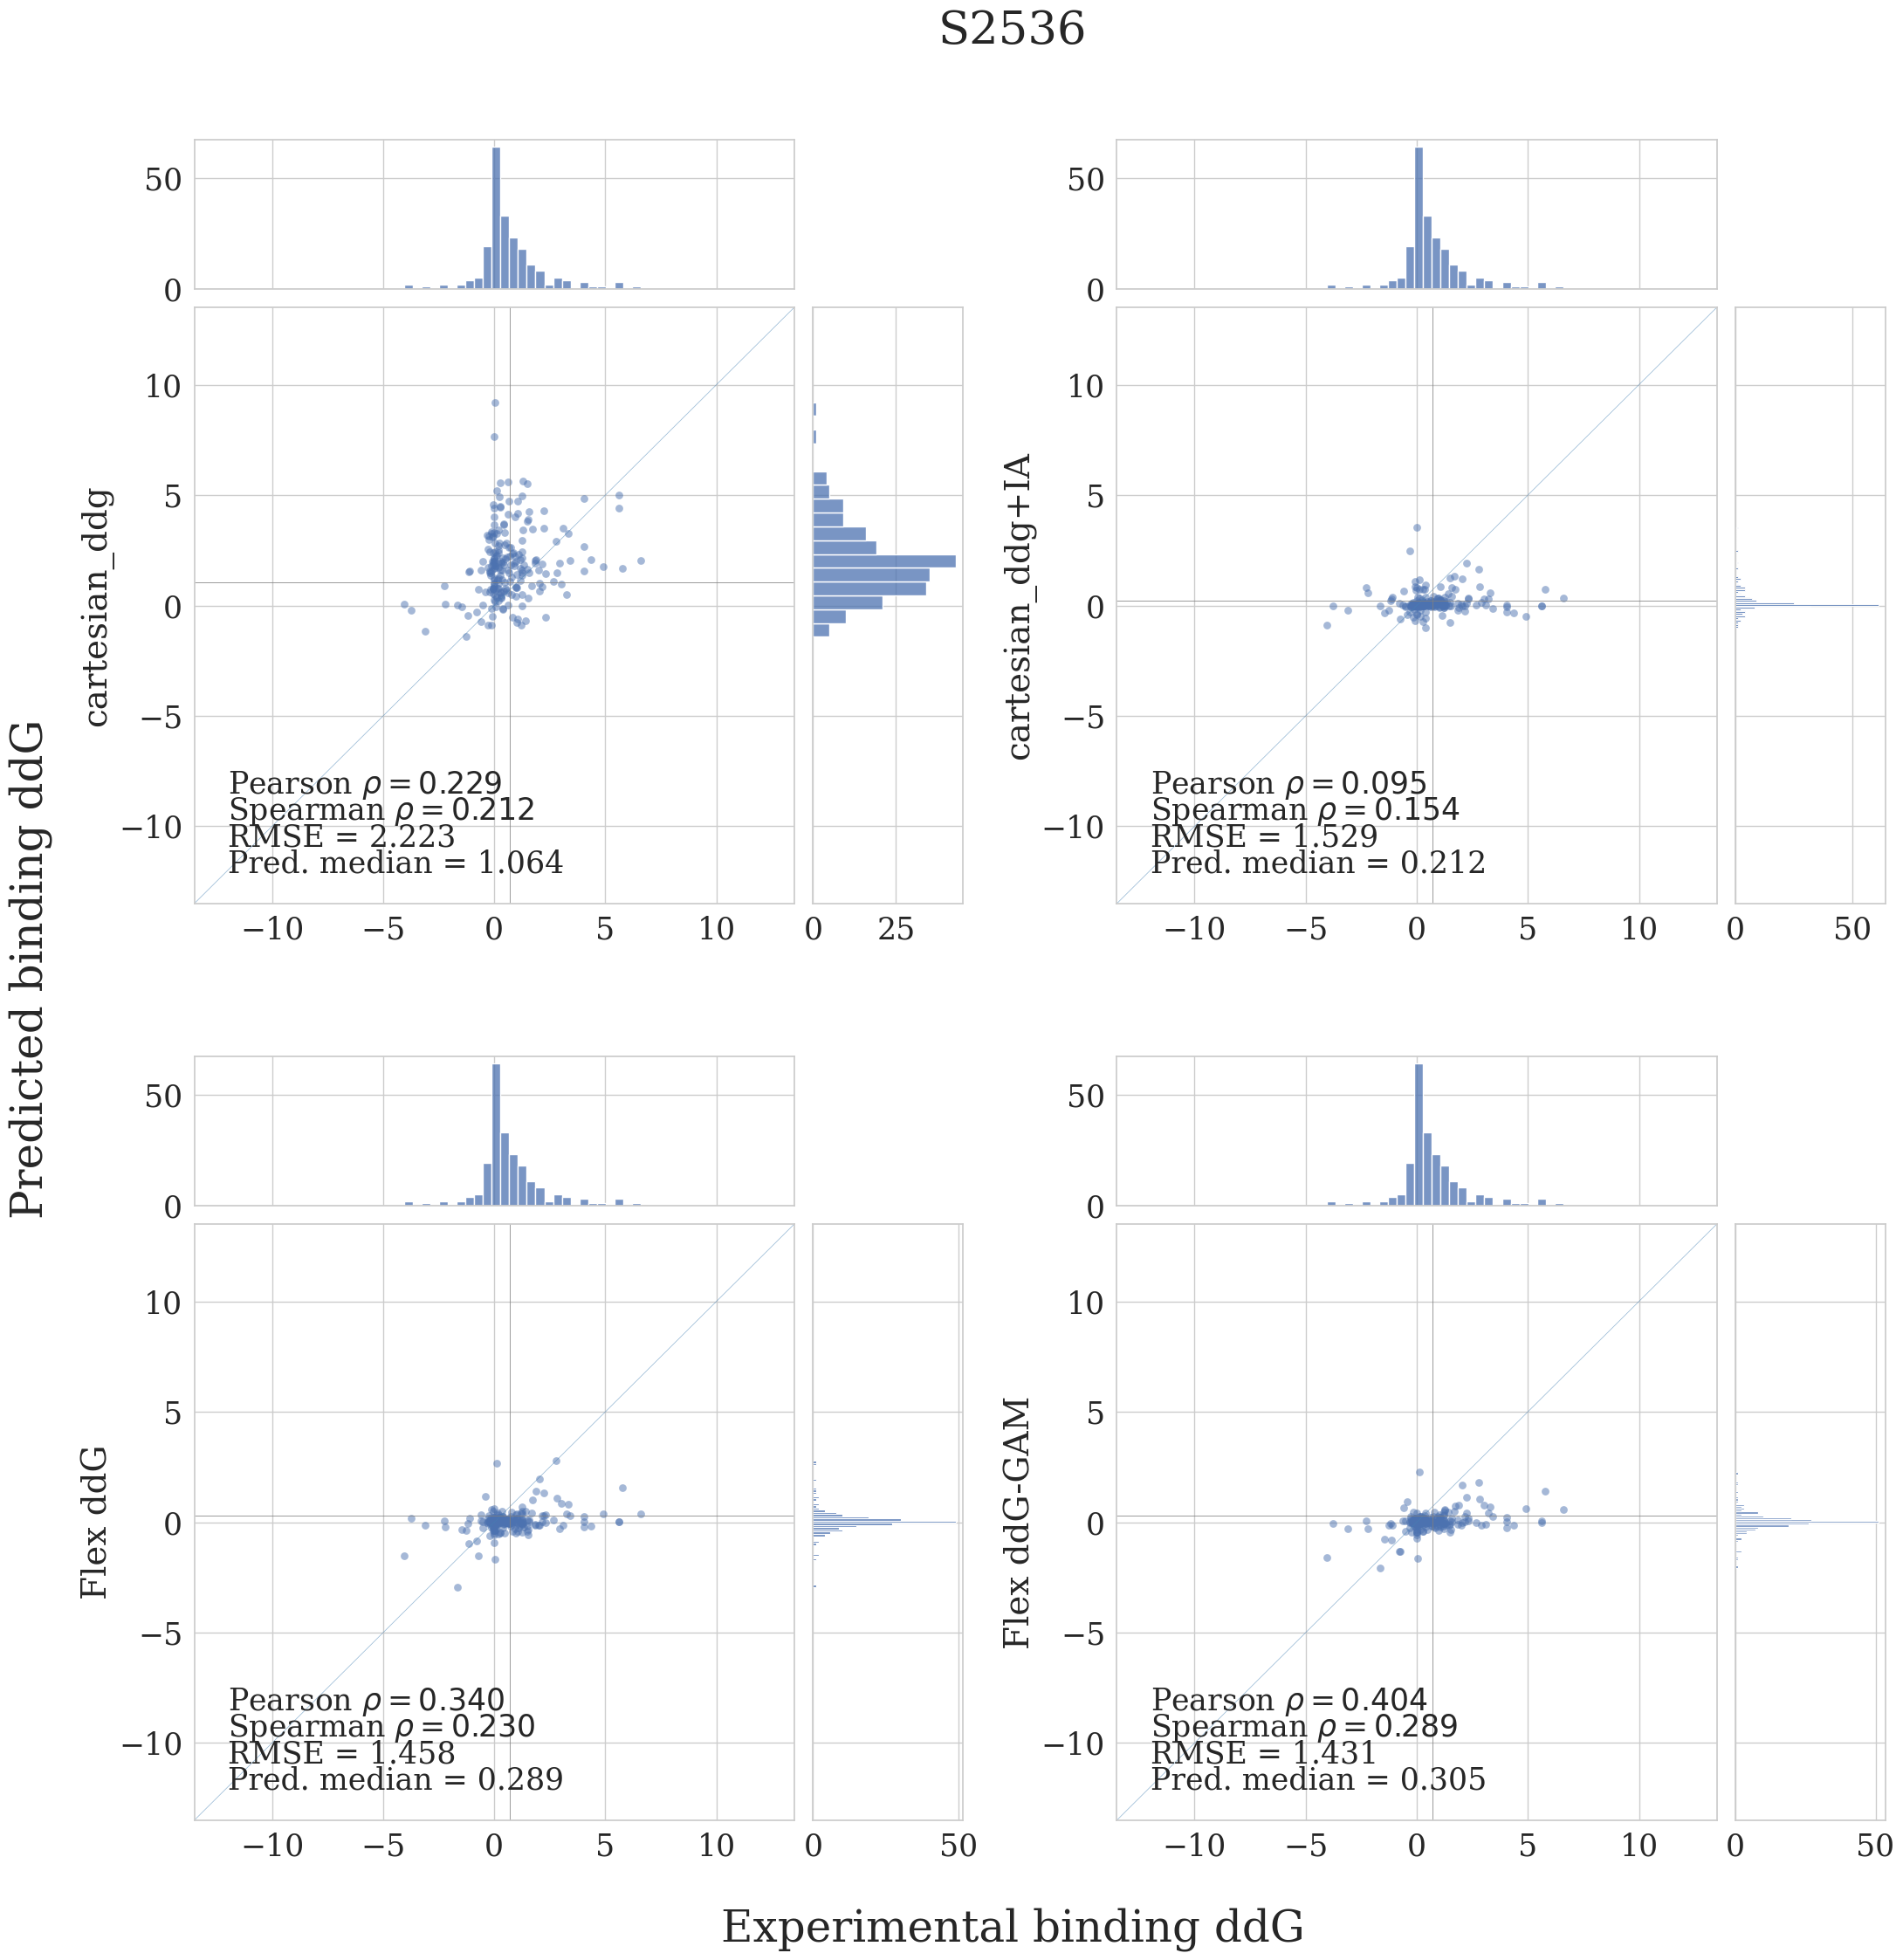

In [31]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt

methods_suppl_plot = {'mean_ddG': 'cartesian_ddg',
                      'mean_ddG_infc': 'cartesian_ddg+IA',
                      'flex_ddg': 'Flex ddG',
                      'flex_ddg_gam': 'Flex ddG-GAM'}
df = S2536_sub_flex.loc[S2536_sub_flex['region']=='Interior'].copy()

# Create the main figure
fig = plt.figure(figsize=(25, 25))

# Create a 2x2 GridSpec for the overall layout
outer_grid = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.2)

# Loop through the methods and the grid locations
for i, meth in enumerate(methods_suppl_plot.keys()):
    # Create a nested GridSpec for each plot (scatter + marginals)
    # Define ratios to make the central plot larger than the marginals
    inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid[i],
                                                  width_ratios=(4, 1), height_ratios=(1, 4),
                                                  wspace=0.05, hspace=0.05)

    # Create axes from the inner grid
    ax_scatter = fig.add_subplot(inner_grid[1, 0])
    ax_histx = fig.add_subplot(inner_grid[0, 0], sharex=ax_scatter)
    ax_histy = fig.add_subplot(inner_grid[1, 1], sharey=ax_scatter)

    # Remove tick labels from the marginal histograms for a cleaner look
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # --- Plotting Section ---
    subset = df.dropna(subset=[meth]).copy()

    # Main scatter plot (on the central axis)
    sns.scatterplot(data=subset, x='DDGb', y=meth,
                    alpha=0.5, s=40, linewidth=0,
                    ax=ax_scatter)

    # Marginal histograms
    sns.histplot(data=subset, x='DDGb', ax=ax_histx, kde=False)
    sns.histplot(data=subset, y=meth, ax=ax_histy, kde=False)
    
    # Remove the "Count" labels from the histograms
    ax_histx.set_ylabel('')
    ax_histy.set_xlabel('')

    # --- Original Formatting and Annotation ---
    # Set shared limits for the scatter plot
    ax_scatter.set_xlim(-13.5, 13.5)
    ax_scatter.set_ylim(-13.5, 13.5)
    
    # Add diagonal and median lines to the scatter plot
    ax_scatter.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.5, alpha=0.6)
    ax_scatter.axhline(median_dict[meth], color='gray', ls='-', lw=0.7, alpha=0.8)
    ax_scatter.axvline(median_dict['DDGb'], color='gray', ls='-', lw=0.7, alpha=0.8)

    # Add statistical annotations to the scatter plot
    r, _ = stats.pearsonr(subset['DDGb'], subset[meth])
    ax_scatter.annotate(f'Pearson $\\rho = {r:.3f}$', xy=(-12, -8.5), fontsize=25)
    r, _ = stats.spearmanr(subset['DDGb'], subset[meth])
    ax_scatter.annotate(f'Spearman $\\rho = {r:.3f}$', xy=(-12, -9.7), fontsize=25)
    rmse = sqrt(mean_squared_error(subset['DDGb'], subset[meth]))
    ax_scatter.annotate(f'RMSE = {rmse:.3f}', xy=(-12, -10.9), fontsize=25)
    ax_scatter.annotate(f'Pred. median = {median_dict[meth]:.3f}', xy=(-12, -12.1), fontsize=25)
    
    # Set individual plot titles and remove inner labels
    ax_scatter.set_ylabel(f'{methods_suppl_plot[meth]}', fontsize=28)
    ax_scatter.set_xlabel("")
    # ax_scatter.set_title(f'{methods_suppl_plot[meth]}', fontsize=28)

# --- Final Figure-Level Adjustments ---
fig.suptitle('S2536', fontsize=38, y=0.94)

# Set the single X and Y labels for the entire figure
fig.supxlabel("Experimental binding ddG", fontsize=36, y=0.05)
fig.supylabel("Predicted binding ddG", fontsize=36, x=0.04)

# # Adjust layout to prevent labels from overlapping
#plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])

#plt.savefig(f'Figures/S2536_carts_flexs_marginals.pdf', format='pdf')
# plt.show()

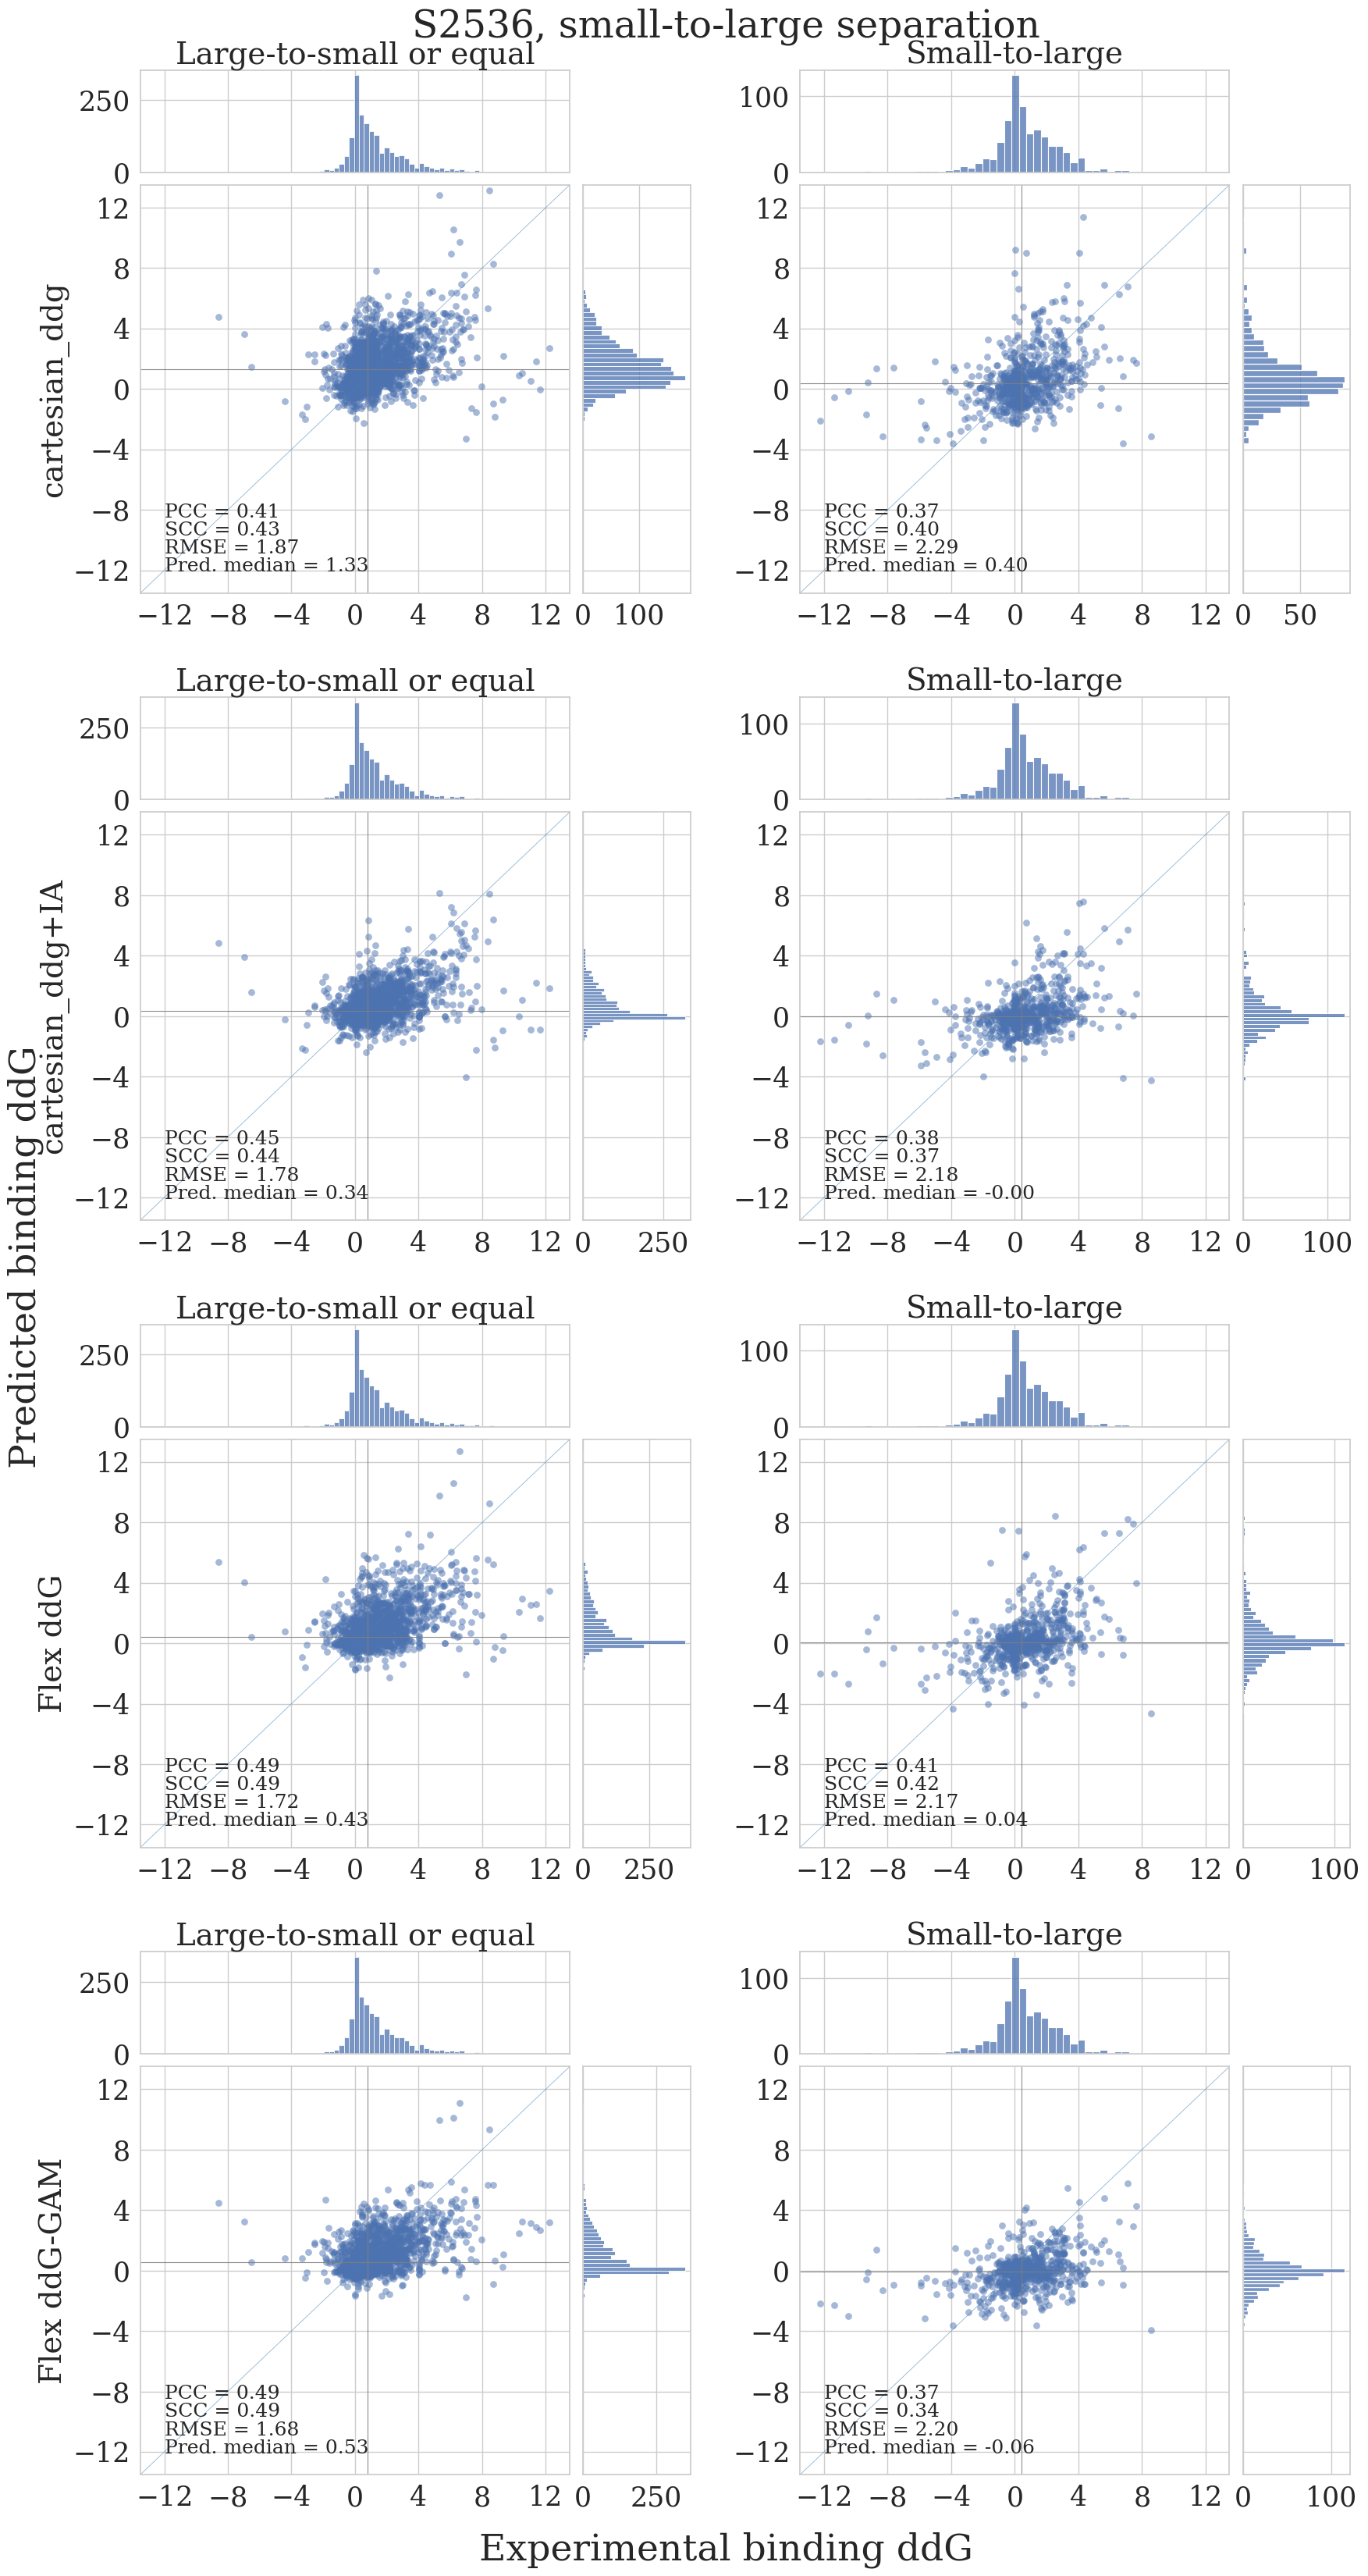

In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt

fig_path = '/groups/sbinlab/panf/SKEMPIv2_benchmark/Figures'
methods_suppl_plot = {'mean_ddG': 'cartesian_ddg',
                      'mean_ddG_infc': 'cartesian_ddg+IA',
                      'flex_ddg': 'Flex ddG',
                      'flex_ddg_gam': 'Flex ddG-GAM'}
df = S2536_sub_flex.copy()

# Create the main figure
fig = plt.figure(figsize=(20, 40))

# Create a 2x2 GridSpec for the overall layout
outer_grid = gridspec.GridSpec(4, 2, figure=fig, wspace=0.2, hspace=0.2)

# Loop through the methods and the grid locations
for i, meth in enumerate(methods_suppl_plot.keys()):
    # Create a nested GridSpec for each plot (scatter + marginals)
    # Define ratios to make the central plot larger than the marginals
    for b in [False, True]:
        if not b:
            ib = i*2
        else:
            ib = (i*2)+1
        inner_grid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer_grid[ib],
                                                      width_ratios=(4, 1), height_ratios=(1, 4),
                                                      wspace=0.05, hspace=0.05)
    
        # Create axes from the inner grid
        ax_scatter = fig.add_subplot(inner_grid[1, 0])
        ax_histx = fig.add_subplot(inner_grid[0, 0], sharex=ax_scatter)
        ax_histy = fig.add_subplot(inner_grid[1, 1], sharey=ax_scatter)
    
        # Remove tick labels from the marginal histograms for a cleaner look
        ax_histx.tick_params(axis="x", labelbottom=False)
        ax_histy.tick_params(axis="y", labelleft=False)
    
        # --- Plotting Section ---
        subset = df.dropna(subset=[meth]).copy()
        subset = subset.loc[subset['small-to-large']==b]
    
        # Main scatter plot (on the central axis)
        sns.scatterplot(data=subset, x='DDGb', y=meth,
                        alpha=0.5, s=40, linewidth=0,
                        ax=ax_scatter)
    
        # Marginal histograms
        sns.histplot(data=subset, x='DDGb', ax=ax_histx, kde=False)
        sns.histplot(data=subset, y=meth, ax=ax_histy, kde=False)
        
        # Remove the "Count" labels from the histograms
        ax_histx.set_ylabel('')
        ax_histy.set_xlabel('')
    
        # --- Original Formatting and Annotation ---
        # Set shared limits for the scatter plot
        # ax_scatter.set_xlim(-0.5, 5)
        # ax_scatter.set_ylim(-0.5, 5)
        ax_scatter.set_xlim(-13.5, 13.5)
        ax_scatter.set_ylim(-13.5, 13.5)
        ax_scatter.set_xticks(np.arange(-12, 16, 4))
        ax_scatter.set_yticks(np.arange(-12, 16, 4))
        
        # Add diagonal and median lines to the scatter plot
        ax_scatter.plot([-15, 15], [-15, 15], color='steelblue', ls='-', lw=0.6, alpha=0.6)
        ax_scatter.axhline(subset[meth].median(), color='gray', ls='-', lw=0.8, alpha=0.9)
        ax_scatter.axvline(subset['DDGb'].median(), color='gray', ls='-', lw=0.8, alpha=0.9)
    
        # Add statistical annotations to the scatter plot
        #ax_scatter.annotate(f'Sample size = {len(subset)}', xy=(2.0, -0.8), fontsize=20)
        r, _ = stats.pearsonr(subset['DDGb'], subset[meth])
        ax_scatter.annotate(f'PCC = {r:.2f}', xy=(-12, -8.5), fontsize=18)
        r, _ = stats.spearmanr(subset['DDGb'], subset[meth])
        ax_scatter.annotate(f'SCC = {r:.2f}', xy=(-12, -9.7), fontsize=18)
        rmse = sqrt(mean_squared_error(subset['DDGb'], subset[meth]))
        ax_scatter.annotate(f'RMSE = {rmse:.2f}', xy=(-12, -10.9), fontsize=18)
        ax_scatter.annotate(f'Pred. median = {subset[meth].median():.2f}', xy=(-12, -12.1), fontsize=18)
        
        # Set individual plot titles and remove inner labels
        if not b:
            ax_scatter.set_ylabel(f'{methods_suppl_plot[meth]}', fontsize=28)
            #ax_scatter.set_title('Large-to-small or equal')
            ax_histx.set_title('Large-to-small or equal', fontsize=28)
        else:
            ax_scatter.set_ylabel('')
            #ax_scatter.set_title('Small-to-large')
            ax_histx.set_title('Small-to-large', fontsize=28)
            
        ax_scatter.set_xlabel("")
        # ax_scatter.set_title(f'{methods_suppl_plot[meth]}', fontsize=28)

# --- Final Figure-Level Adjustments ---
fig.suptitle('S2536, small-to-large separation', fontsize=35, y=0.9)

# Set the single X and Y labels for the entire figure
fig.supxlabel("Experimental binding ddG", fontsize=34, y=0.08)
fig.supylabel("Predicted binding ddG", fontsize=34, x=0.04)

# # Adjust layout to prevent labels from overlapping
#plt.tight_layout(rect=[0.03, 0.03, 1, 0.97])

plt.savefig(os.path.join(fig_path, 'S2536_carts_flexs_stl_marg.pdf'), format='pdf')
# plt.show()

In [17]:
subset = df.dropna(subset=[meth]).copy()
subset = subset.loc[subset['small-to-large']==True]
print(len(subset))

711


In [ ]:
residue_asa_3 = {
    'GLY': 47.155,
    'ALA': 61.063,
    'SER': 69.073,
    'CYS': 78.62,
    'PRO': 81.03,
    'THR': 82.92,
    'ASP': 86.142,
    'VAL': 90.264,
    'ASN': 90.541,
    'GLU': 102.57,
    'ILE': 105.307,
    'LEU': 105.842,
    'GLN': 106.534,
    'HIS': 110.864,
    'MET': 112.01,
    'LYS': 120.502,
    'PHE': 124.714,
    'TYR': 130.885,
    'ARG': 138.595,
    'TRP': 148.915
}

residue_asa_1 = {
    'G': 47.155,
    'A': 61.063,
    'S': 69.073,
    'C': 78.62,
    'P': 81.03,
    'T': 82.92,
    'D': 86.142,
    'V': 90.264,
    'N': 90.541,
    'E': 102.57,
    'I': 105.307,
    'L': 105.842,
    'Q': 106.534,
    'H': 110.864,
    'M': 112.01,
    'K': 120.502,
    'F': 124.714,
    'Y': 130.885,
    'R': 138.595,
    'W': 148.915
}